# Nutrition Health Survey- Age Prediction Summer Analytics 2025, IIT Guwahati

## Problem Statement
Predict whether a person is an Adult (0) or Senior (1) based on health and demographic features.

**Evaluation Metric:** F1-Score

## Dataset Overview
- **Training Data:** 1967 samples with target variable `age_group`
- **Test Data:** 313 samples (predict age_group)
- **Features:** SEQN, RIAGENDR, PAQ605, BMXBMI, LBXGLU, DIQ010, LBXGLT, LBXIN

---

## Table of Contents
1. [Data Loading & Initial Exploration](#1-data-loading--initial-exploration)
2. [Exploratory Data Analysis (EDA)](#2-exploratory-data-analysis-eda)
3. [Feature Engineering](#3-feature-engineering)
4. [Model Selection & Training](#4-model-selection--training)
5. [Threshold Optimization](#5-threshold-optimization)
6. [Handling Class Imbalance](#6-handling-class-imbalance)
7. [Evaluation & Model Selection](#7-evaluation--model-selection)
8. [Error Analysis](#8-error-analysis)
9. [Final Model & Submission](#9-final-model--submission)

In [105]:
!pip uninstall imbalanced-learn -y
!pip install scikit-learn==1.3.2
!pip install imbalanced-learn==0.11.0 --no-deps
!pip install threadpoolctl joblib



Found existing installation: imbalanced-learn 0.11.0
Uninstalling imbalanced-learn-0.11.0:
  Successfully uninstalled imbalanced-learn-0.11.0



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [106]:
import sys
import importlib

if 'sklearn' in sys.modules:
    importlib.reload(sys.modules['sklearn'])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, 
    RandomizedSearchCV, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, 
    precision_score, recall_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.neighbors import NearestNeighbors

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

class ProfessionalSMOTE:

    def __init__(self, random_state=42, k_neighbors=5, sampling_strategy='auto'):
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.sampling_strategy = sampling_strategy
        np.random.seed(random_state)
    
    def fit_resample(self, X, y):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        y_series = pd.Series(y) if not isinstance(y, pd.Series) else y.copy()
        
        # Get class counts
        class_counts = y_series.value_counts().sort_index()
        classes = class_counts.index.tolist()
        
        if self.sampling_strategy == 'auto':
            target_count = class_counts.max()
        else:
            target_count = class_counts.max()
        
        X_resampled = X_df.copy()
        y_resampled = y_series.copy()
        
        for class_label in classes:
            current_count = class_counts[class_label]
            if current_count < target_count:
                samples_needed = target_count - current_count
                
                class_samples = X_df[y_series == class_label]
                
                if len(class_samples) == 1:
                    synthetic_samples = self._generate_single_sample_synthetic(
                        class_samples.iloc[0], samples_needed
                    )
                elif len(class_samples) < self.k_neighbors:
                    synthetic_samples = self._generate_knn_synthetic(
                        class_samples, samples_needed, min(len(class_samples)-1, 1)
                    )
                else:
                    synthetic_samples = self._generate_knn_synthetic(
                        class_samples, samples_needed, self.k_neighbors
                    )
                
                if len(synthetic_samples) > 0:
                    synthetic_df = pd.DataFrame(synthetic_samples, columns=X_df.columns)
                    synthetic_labels = pd.Series([class_label] * len(synthetic_samples))
                    
                    X_resampled = pd.concat([X_resampled, synthetic_df], ignore_index=True)
                    y_resampled = pd.concat([y_resampled, synthetic_labels], ignore_index=True)
        
        return X_resampled, y_resampled
    
    def _generate_single_sample_synthetic(self, sample, n_samples):
        synthetic_samples = []
        for _ in range(n_samples):
            noise = np.random.normal(0, 0.1, len(sample))
            synthetic_sample = sample + noise
            synthetic_samples.append(synthetic_sample.values)
        return synthetic_samples
    
    def _generate_knn_synthetic(self, class_samples, n_samples, k):
        if k <= 0:
            return self._generate_single_sample_synthetic(class_samples.iloc[0], n_samples)
        
        knn = NearestNeighbors(n_neighbors=min(k, len(class_samples)-1))
        knn.fit(class_samples.values)
        
        synthetic_samples = []
        
        for _ in range(n_samples):
            sample_idx = np.random.choice(len(class_samples))
            sample = class_samples.iloc[sample_idx].values.reshape(1, -1)
            
            distances, neighbor_indices = knn.kneighbors(sample)
            
            if len(neighbor_indices[0]) > 0:
                neighbor_idx = np.random.choice(neighbor_indices[0])
                neighbor = class_samples.iloc[neighbor_idx].values
                
                alpha = np.random.random()
                synthetic_sample = sample.flatten() + alpha * (neighbor - sample.flatten())
                synthetic_samples.append(synthetic_sample)
            else:
                noise = np.random.normal(0, 0.1, len(sample.flatten()))
                synthetic_sample = sample.flatten() + noise
                synthetic_samples.append(synthetic_sample)
        
        return synthetic_samples

# SMOTE instance
SMOTE = ProfessionalSMOTE
SMOTE_AVAILABLE = True

# Test 
try:
    X_test = np.array([[1, 2], [2, 3], [3, 4], [1, 3], [2, 4], [3, 5]])
    y_test = np.array([0, 0, 1, 0, 1, 1])
    
    smote_test = SMOTE(random_state=42)
    X_res, y_res = smote_test.fit_resample(X_test, y_test)
    
    print("SMOTE works ")
    print(f"Original samples: {len(X_test)}")
    print(f"Resampled samples: {len(X_res)}")
    print(f"Original class distribution: {np.bincount(y_test)}")
    print(f"Resampled class distribution: {np.bincount(y_res)}")
    
except Exception as e:
    print(f"Error in SMOTE implementation: {e}")
    SMOTE_AVAILABLE = False

# Hyperparameter 
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Optuna error")
    OPTUNA_AVAILABLE = False

try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\n" + "="*60)
print("="*60)
print(f"📊 SMOTE Available: {SMOTE_AVAILABLE} ")
print(f"🔧 Optuna Available: {OPTUNA_AVAILABLE}")
print(f"📈 Plotly Available: {PLOTLY_AVAILABLE}")
print("="*60)

SMOTE works 
Original samples: 6
Resampled samples: 6
Original class distribution: [3 3]
Resampled class distribution: [3 3]

📊 SMOTE Available: True 
🔧 Optuna Available: True
📈 Plotly Available: True


## 1. Data Loading & Initial Exploration

In [107]:
train_df = pd.read_csv('Train_Data.csv')
test_df = pd.read_csv('Test_Data.csv')
sample_sub = pd.read_csv('Sample_Submission.csv')

print(f"Training Data: {train_df.shape}")
print(f"Test Data: {test_df.shape}")
print(f"Sample Submission: {sample_sub.shape}")

print("\n Training Data Info:")
print(train_df.info())

print("\n Test Data Info:")
print(test_df.info())

print("\n First 5 rows of training data:")
train_df.head()

Training Data: (1966, 9)
Test Data: (312, 8)
Sample Submission: (312, 1)

 Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIAGENDR   1948 non-null   float64
 2   PAQ605     1953 non-null   float64
 3   BMXBMI     1948 non-null   float64
 4   LBXGLU     1953 non-null   float64
 5   DIQ010     1948 non-null   float64
 6   LBXGLT     1955 non-null   float64
 7   LBXIN      1957 non-null   float64
 8   age_group  1952 non-null   object 
dtypes: float64(8), object(1)
memory usage: 138.4+ KB
None

 Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      310 non-null    float64
 1   RIAGENDR  310 non-null    float64
 2   PAQ605    311 non

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [108]:
print(train_df.describe())
print(test_df.describe())
print("\n Missing Values in Training Data:")
missing_train = train_df.isnull().sum()
missing_train_pct = (missing_train / len(train_df)) * 100
missing_info_train = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing Percentage': missing_train_pct
}).sort_values('Missing Count', ascending=False)
print(missing_info_train[missing_info_train['Missing Count'] > 0])

print("\n Missing Values in Test Data:")
missing_test = test_df.isnull().sum()
missing_test_pct = (missing_test / len(test_df)) * 100
missing_info_test = pd.DataFrame({
    'Missing Count': missing_test,
    'Missing Percentage': missing_test_pct
}).sort_values('Missing Count', ascending=False)
print(missing_info_test[missing_info_test['Missing Count'] > 0])

               SEQN     RIAGENDR       PAQ605       BMXBMI       LBXGLU  \
count   1954.000000  1948.000000  1953.000000  1948.000000  1953.000000   
mean   78683.621801     1.510267     1.825397    27.965400    99.491039   
std     2924.115709     0.500023     0.399449     7.327616    16.774665   
min    73564.000000     1.000000     1.000000    14.500000    63.000000   
25%    76194.000000     1.000000     2.000000    22.800000    91.000000   
50%    78717.000000     2.000000     2.000000    26.800000    97.000000   
75%    81217.000000     2.000000     2.000000    31.300000   104.000000   
max    83727.000000     2.000000     7.000000    70.100000   405.000000   

            DIQ010       LBXGLT        LBXIN  
count  1948.000000  1955.000000  1957.000000  
mean      2.015914   115.150384    11.862892  
std       0.187579    46.271615     9.756713  
min       1.000000    40.000000     0.140000  
25%       2.000000    87.000000     5.800000  
50%       2.000000   105.000000     9.0300

Class Distribution (Target Variable):
           Count  Percentage
age_group                   
Adult       1638   83.913934
Senior       314   16.086066

 Class Balance:
Adult (0): 1652 (84.03%)
Senior (1): 314 (15.97%)


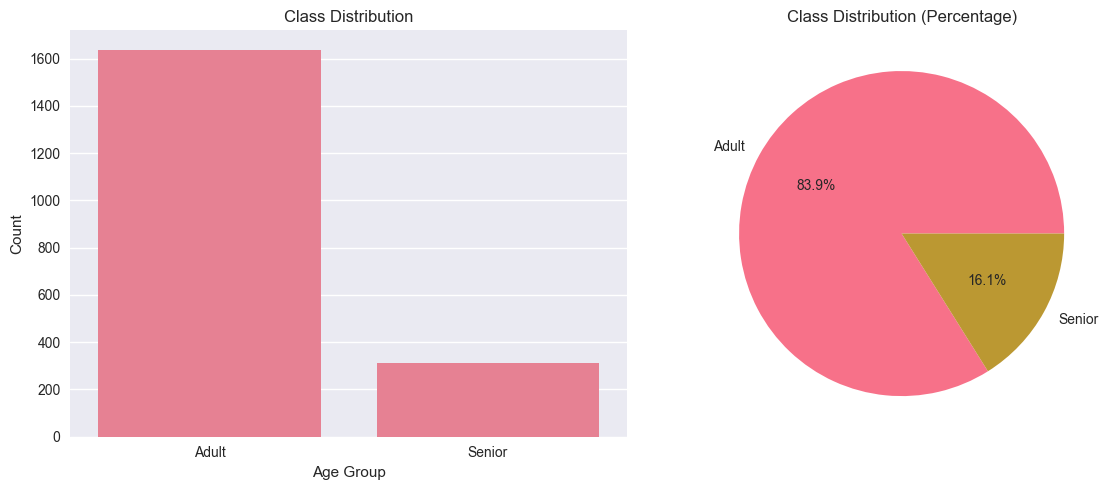

In [109]:
print("Class Distribution (Target Variable):")
class_dist = train_df['age_group'].value_counts()
class_dist_pct = train_df['age_group'].value_counts(normalize=True) * 100

class_info = pd.DataFrame({
    'Count': class_dist,
    'Percentage': class_dist_pct
})
print(class_info)

# Convert text labels to binary 
train_df['age_group_binary'] = (train_df['age_group'] == 'Senior').astype(int)

print(f"\n Class Balance:")
print(f"Adult (0): {(train_df['age_group_binary'] == 0).sum()} ({((train_df['age_group_binary'] == 0).sum() / len(train_df) * 100):.2f}%)")
print(f"Senior (1): {(train_df['age_group_binary'] == 1).sum()} ({((train_df['age_group_binary'] == 1).sum() / len(train_df) * 100):.2f}%)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(data=train_df, x='age_group', ax=ax1)
ax1.set_title('Class Distribution')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Count')

train_df['age_group'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Class Distribution (Percentage)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## 2. Exploratory Data Analysis (EDA)

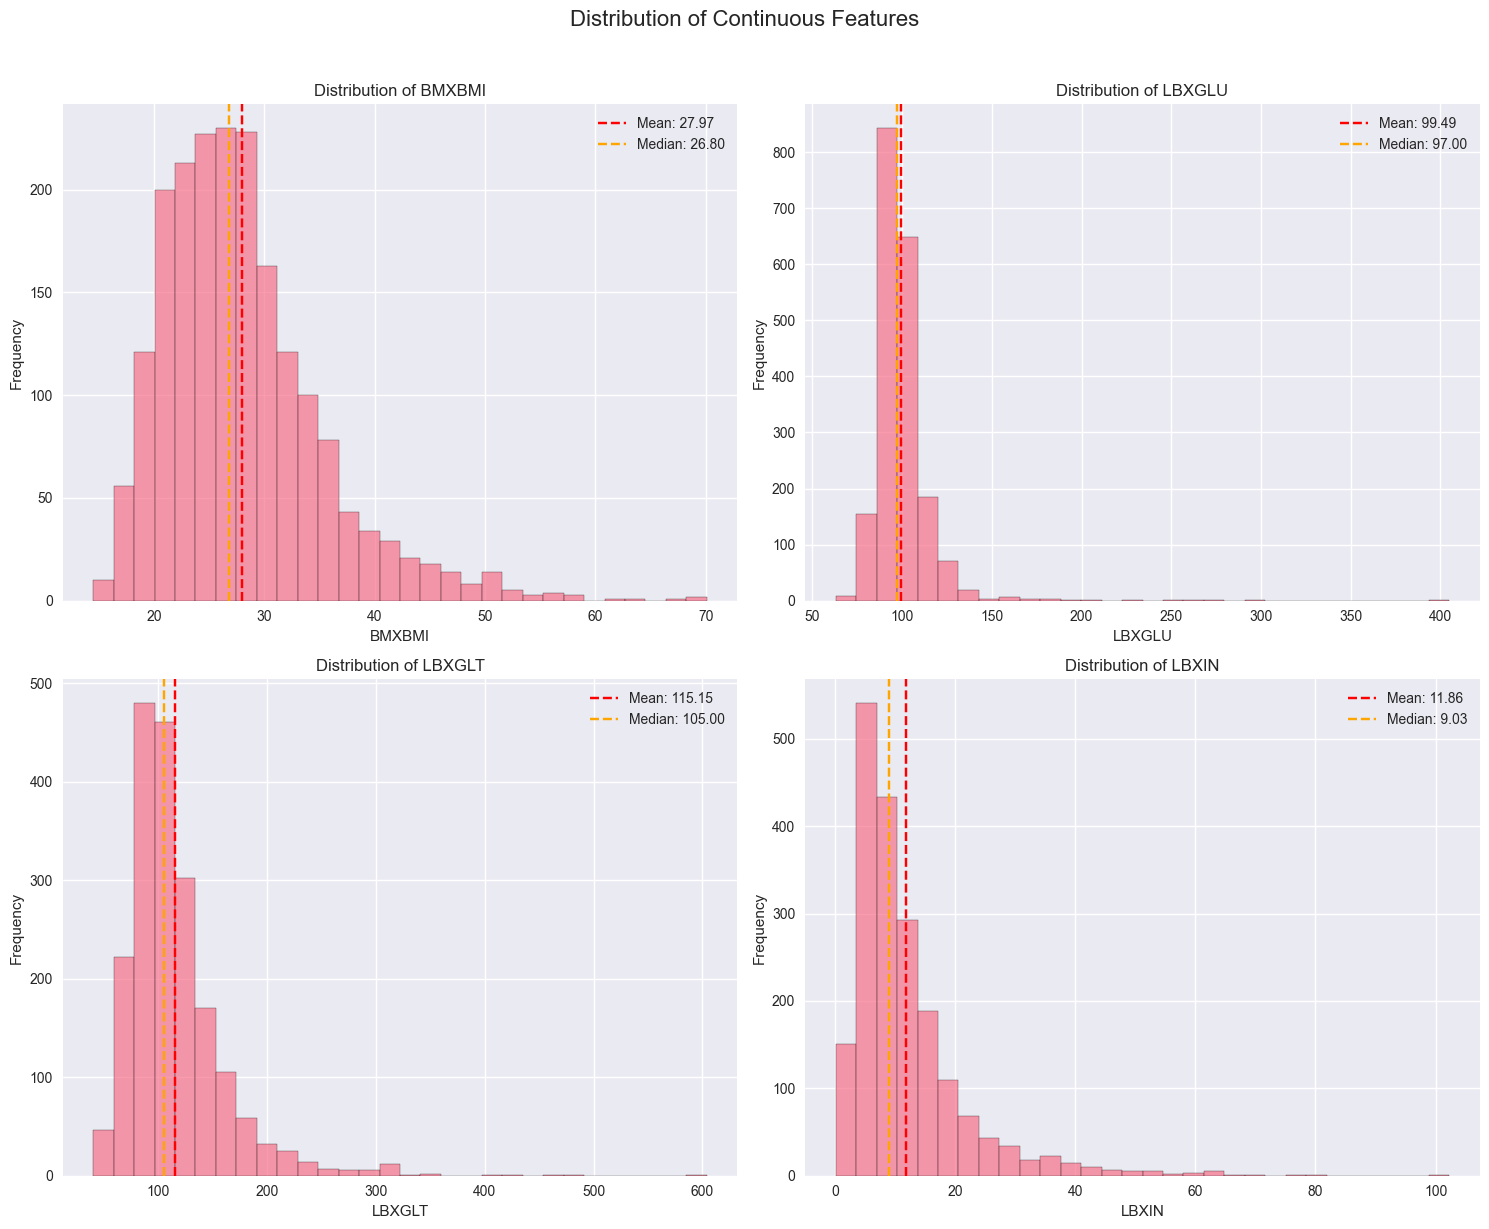

Skewness of Continuous Features:
  Feature  Skewness
0  BMXBMI  1.355254
1  LBXGLU  6.479067
2  LBXGLT  2.696625
3   LBXIN  2.706547


In [110]:
continuous_features = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
categorical_features = ['RIAGENDR', 'PAQ605', 'DIQ010']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(continuous_features):
    data_clean = train_df[feature].dropna()
    
    axes[i].hist(data_clean, bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    
    mean_val = data_clean.mean()
    median_val = data_clean.median()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='orange', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.suptitle('Distribution of Continuous Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Skewness of Continuous Features:")
skewness_info = pd.DataFrame({
    'Feature': continuous_features,
    'Skewness': [train_df[feature].skew() for feature in continuous_features]
})
print(skewness_info)

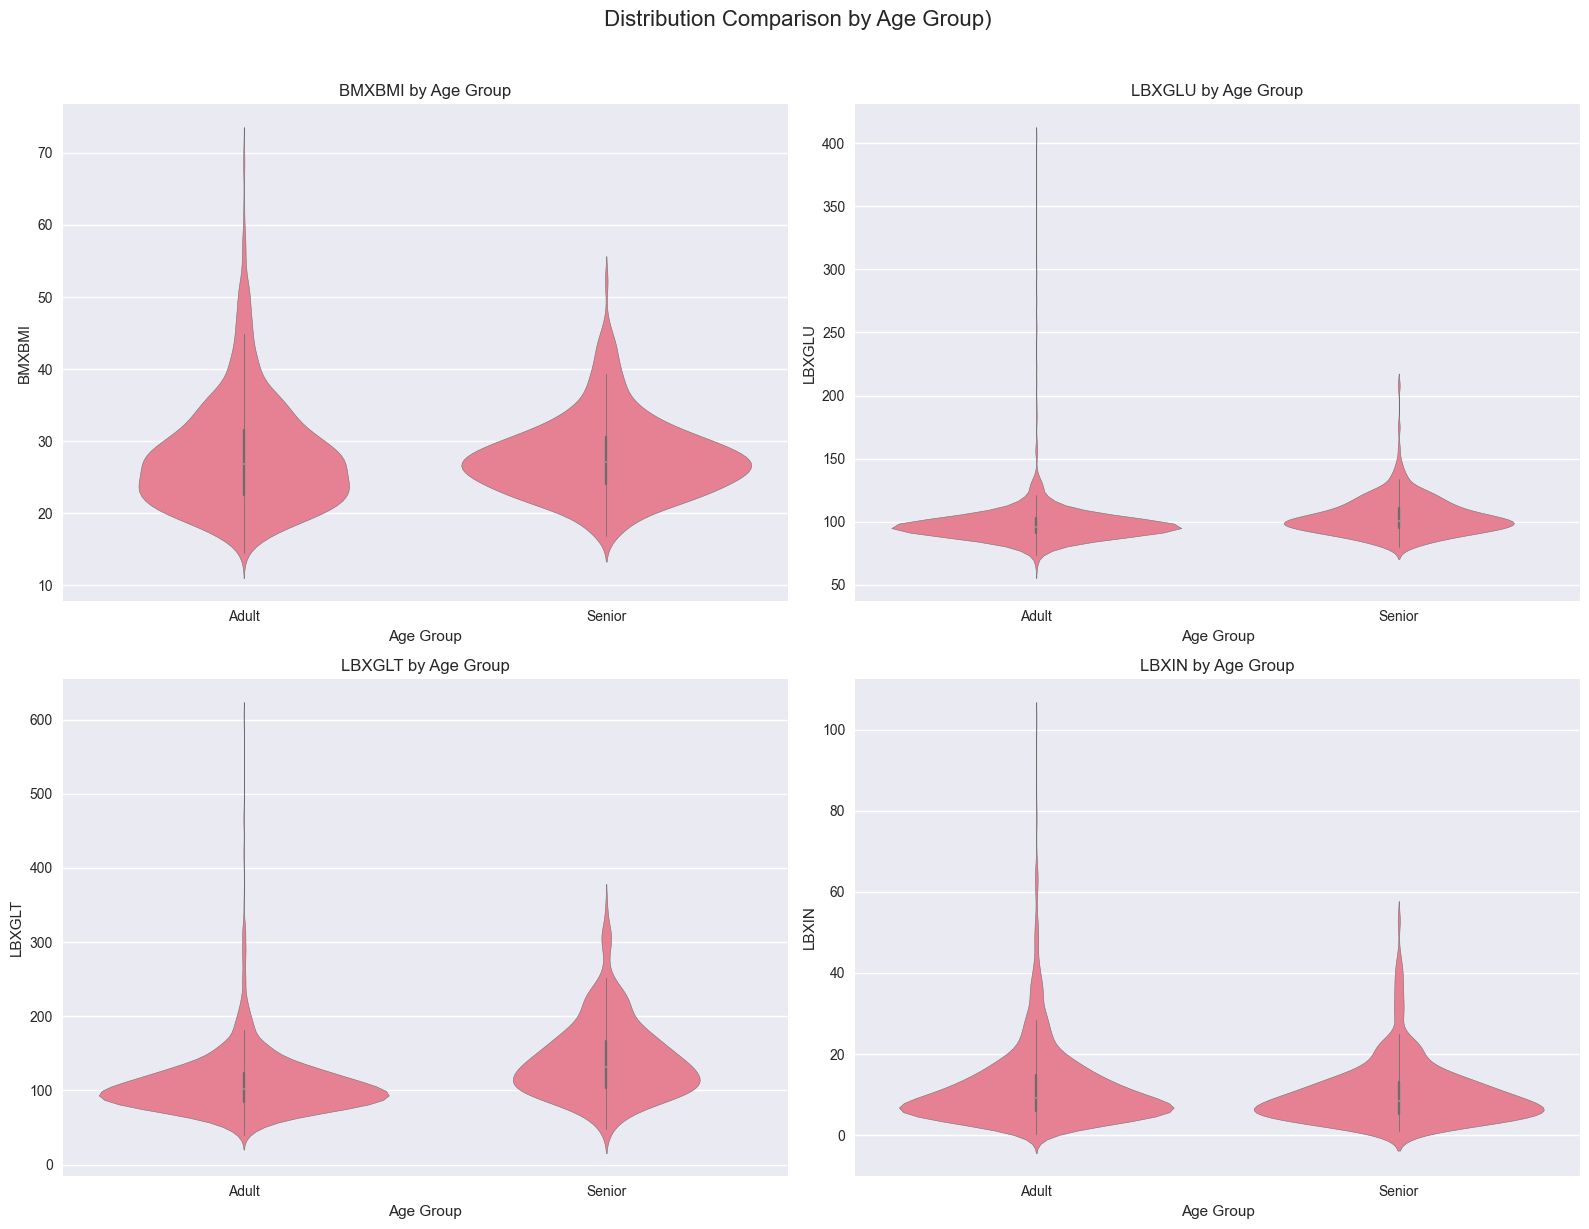

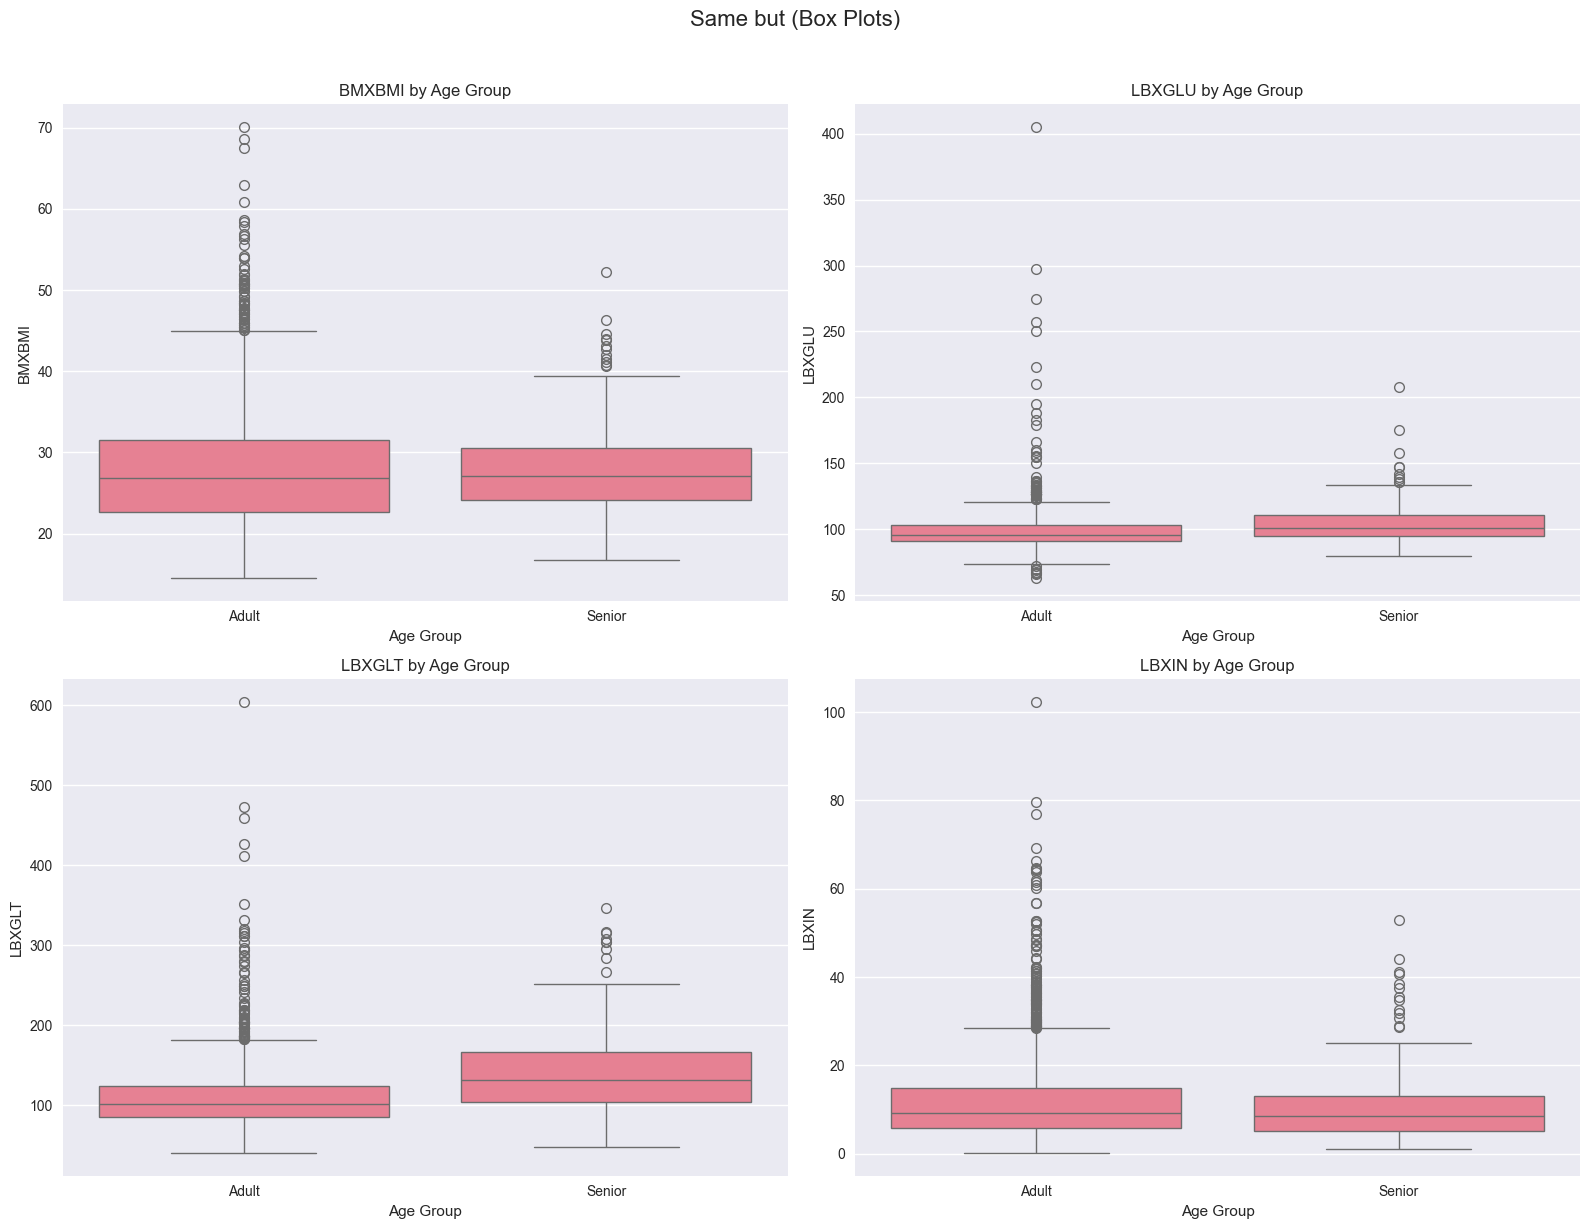

Statistical Comparison between Age Groups:

BMXBMI:
  Adult Mean: 28.02 ± 7.65
  Senior Mean: 27.78 ± 5.49
  T-test p-value: 0.6041
  Significant difference: No

LBXGLU:
  Adult Mean: 98.53 ± 16.91
  Senior Mean: 104.40 ± 14.87
  T-test p-value: 0.0000
  Significant difference: Yes

LBXGLT:
  Adult Mean: 110.02 ± 43.30
  Senior Mean: 141.36 ± 51.28
  T-test p-value: 0.0000
  Significant difference: Yes

LBXIN:
  Adult Mean: 12.15 ± 10.11
  Senior Mean: 10.42 ± 7.65
  T-test p-value: 0.0040
  Significant difference: Yes


In [111]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(continuous_features):
    sns.violinplot(data=train_df, x='age_group', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Age Group')
    axes[i].set_xlabel('Age Group')
    axes[i].set_ylabel(feature)

plt.suptitle(' Distribution Comparison by Age Group)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, feature in enumerate(continuous_features):
    sns.boxplot(data=train_df, x='age_group', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Age Group')
    axes[i].set_xlabel('Age Group')
    axes[i].set_ylabel(feature)

plt.suptitle('Same but (Box Plots)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Statistical Comparison between Age Groups:")
for feature in continuous_features:
    adult_data = train_df[train_df['age_group'] == 'Adult'][feature].dropna()
    senior_data = train_df[train_df['age_group'] == 'Senior'][feature].dropna()
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(adult_data, senior_data)
    
    print(f"\n{feature}:")
    print(f"  Adult Mean: {adult_data.mean():.2f} ± {adult_data.std():.2f}")
    print(f"  Senior Mean: {senior_data.mean():.2f} ± {senior_data.std():.2f}")
    print(f"  T-test p-value: {p_value:.4f}")
    print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

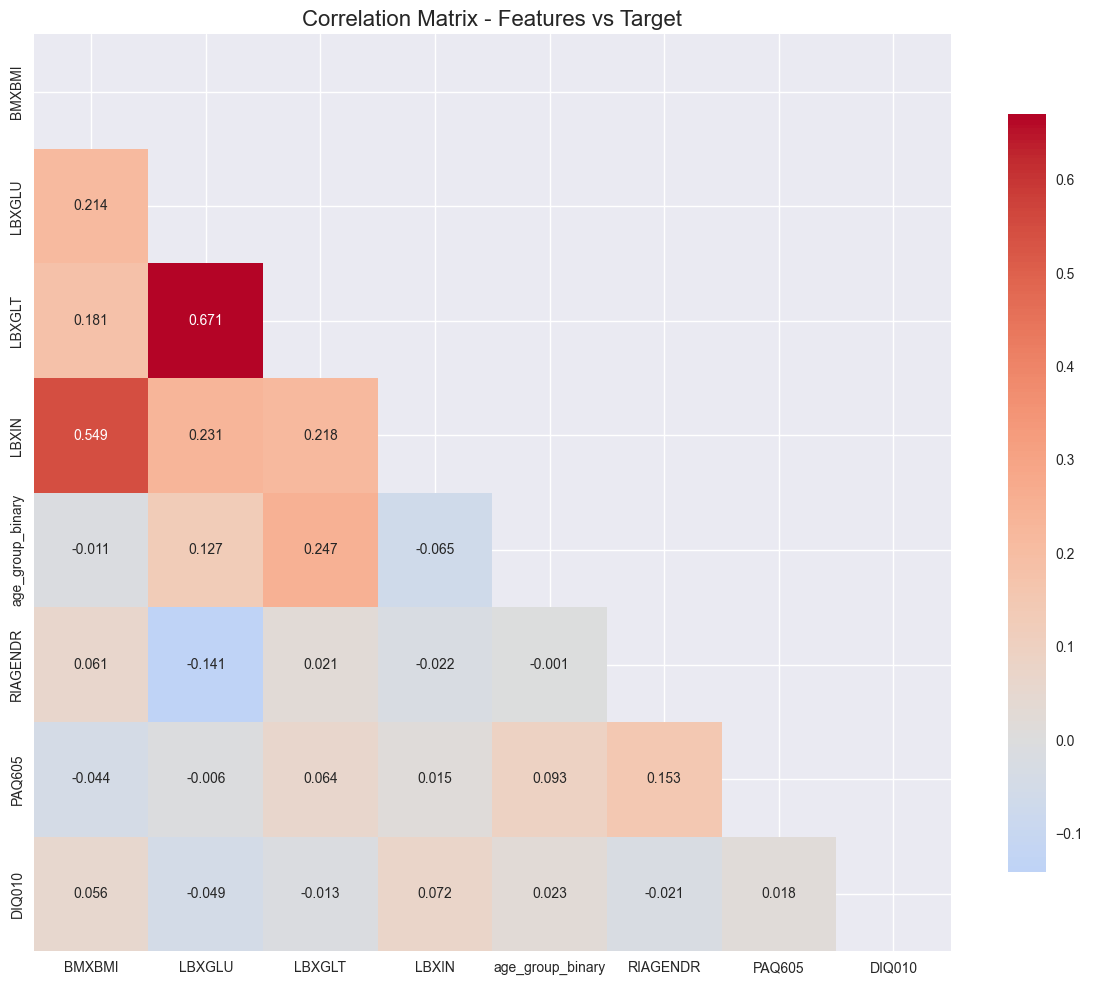

 Feature Correlation with Target 
LBXGLT      0.247377
LBXGLU      0.127148
PAQ605      0.092656
LBXIN      -0.064590
DIQ010      0.022504
BMXBMI     -0.010831
RIAGENDR   -0.000569
Name: age_group_binary, dtype: float64

Potential Multicollinearity (|correlation| > 0.7):
  No high correlations found (>0.7)


In [112]:
numeric_cols = continuous_features + ['age_group_binary'] + categorical_features
corr_data = train_df[numeric_cols].copy()

correlation_matrix = corr_data.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix - Features vs Target', fontsize=16)
plt.tight_layout()
plt.show()

print(" Feature Correlation with Target ")
target_corr = correlation_matrix['age_group_binary'].drop('age_group_binary').sort_values(key=abs, ascending=False)
print(target_corr)

# Check for multicollinearity
print("\nPotential Multicollinearity (|correlation| > 0.7):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            corr_val = correlation_matrix.iloc[i, j]
            high_corr.append((col1, col2, corr_val))
            print(f"  {col1} ↔ {col2}: {corr_val:.3f}")

if not high_corr:
    print("  No high correlations found (>0.7)")

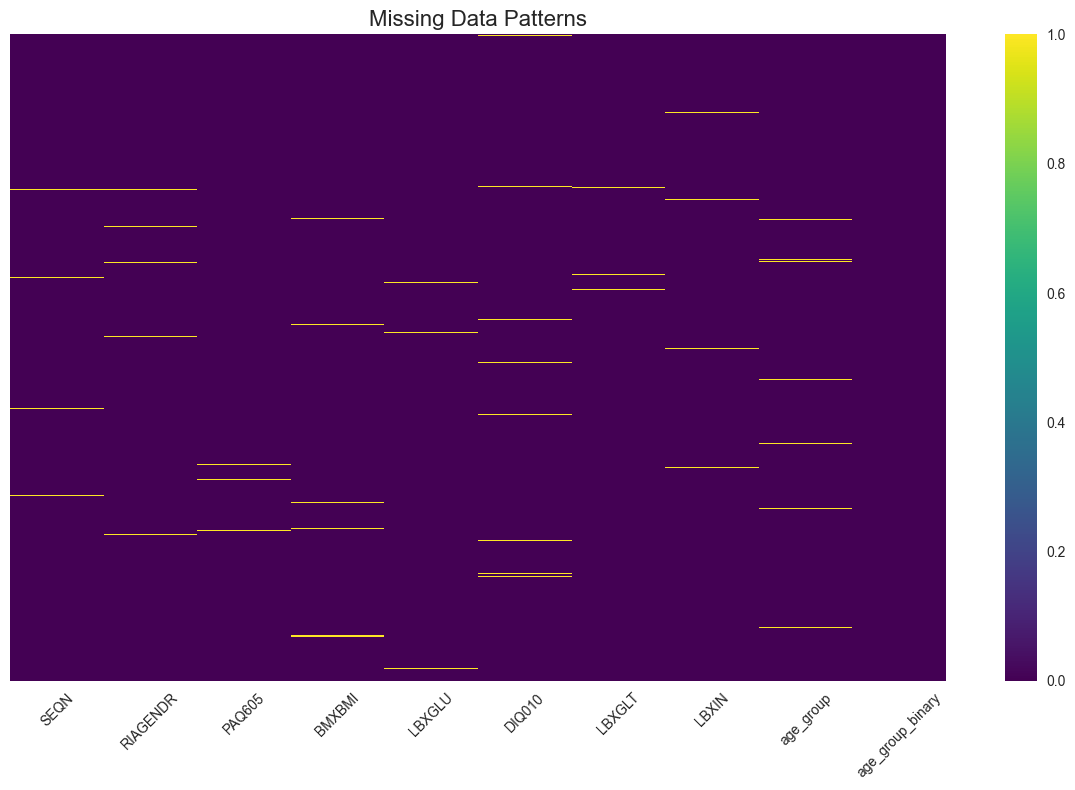

Categorical Features Analysis:

RIAGENDR:
          Count  Percentage
RIAGENDR                   
2.0         994   50.559512
1.0         954   48.524924
NaN          18    0.915565

PAQ605:
        Count  Percentage
PAQ605                   
2.0      1606   81.688708
1.0       346   17.599186
NaN        13    0.661241
7.0         1    0.050865

DIQ010:
        Count  Percentage
DIQ010                   
2.0      1879   95.574771
3.0        50    2.543235
1.0        19    0.966429
NaN        18    0.915565


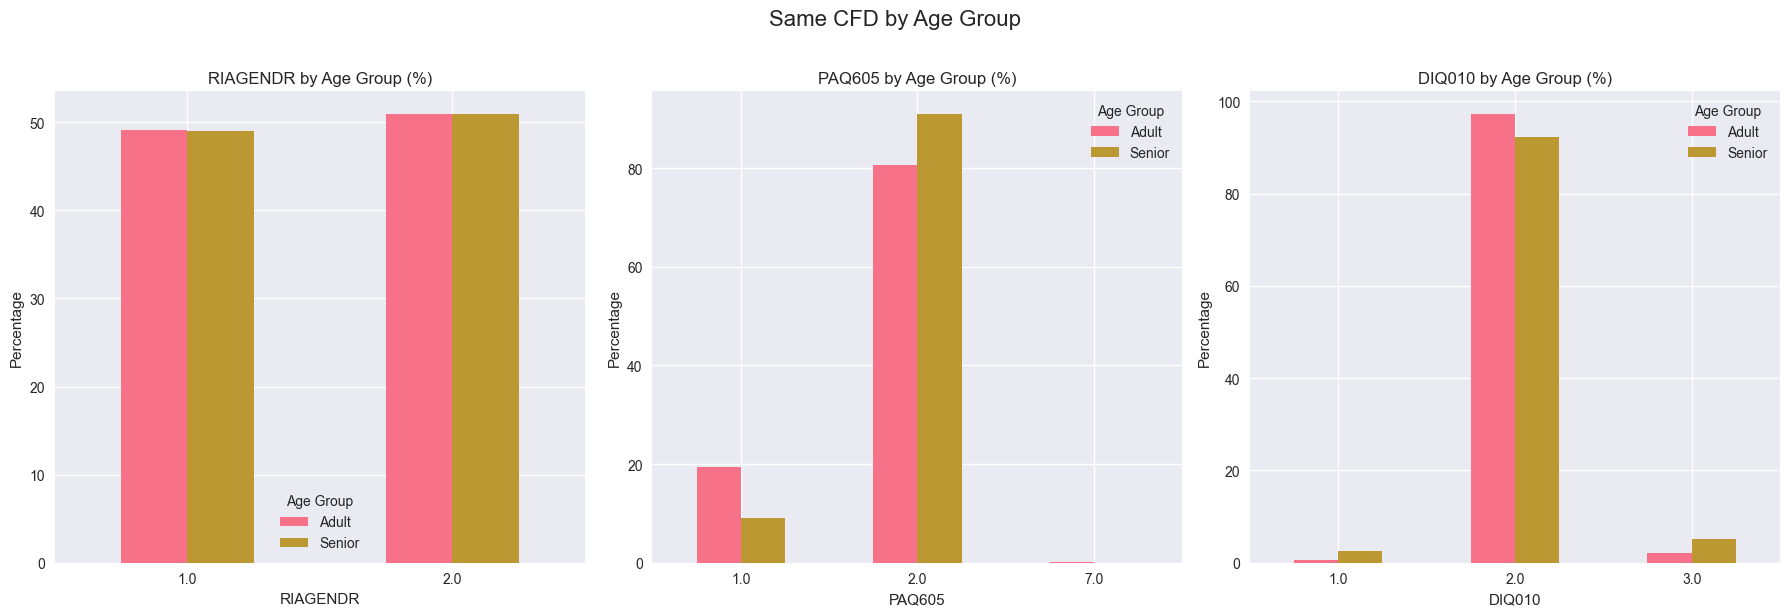


 Chi-square Tests for Categorical Features:

RIAGENDR:
  Chi-square statistic: 0.0000
  P-value: 1.0000
  Significant association: No

PAQ605:
  Chi-square statistic: 19.6313
  P-value: 0.0001
  Significant association: Yes

DIQ010:
  Chi-square statistic: 19.8759
  P-value: 0.0000
  Significant association: Yes


In [113]:
plt.figure(figsize=(12, 8))
missing_data = train_df.isnull()
sns.heatmap(missing_data, 
            yticklabels=False, 
            cbar=True, 
            cmap='viridis',
            xticklabels=True)
plt.title('Missing Data Patterns', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Categorical Features Analysis:")
for feature in categorical_features:
    print(f"\n{feature}:")
    value_counts = train_df[feature].value_counts(dropna=False)
    value_counts_pct = train_df[feature].value_counts(normalize=True, dropna=False) * 100
    
    feature_info = pd.DataFrame({
        'Count': value_counts,
        'Percentage': value_counts_pct
    })
    print(feature_info)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(categorical_features):
    crosstab = pd.crosstab(train_df[feature], train_df['age_group'], normalize='columns') * 100
    crosstab.plot(kind='bar', ax=axes[i], rot=0)
    axes[i].set_title(f'{feature} by Age Group (%)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Percentage')
    axes[i].legend(title='Age Group')

plt.suptitle('Same CFD by Age Group', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Chi-square test for categorical features
print("\n Chi-square Tests for Categorical Features:")
for feature in categorical_features:
    contingency_table = pd.crosstab(train_df[feature], train_df['age_group'])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n{feature}:")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant association: {'Yes' if p_value < 0.05 else 'No'}")

 Outlier Detection using IQR Method:

BMXBMI:
  Outliers: 75 (3.85%)
  Bounds: [10.05, 44.05]

LBXGLU:
  Outliers: 90 (4.61%)
  Bounds: [71.50, 123.50]

LBXGLT:
  Outliers: 97 (4.96%)
  Bounds: [21.00, 197.00]

LBXIN:
  Outliers: 129 (6.59%)
  Bounds: [-7.22, 27.50]


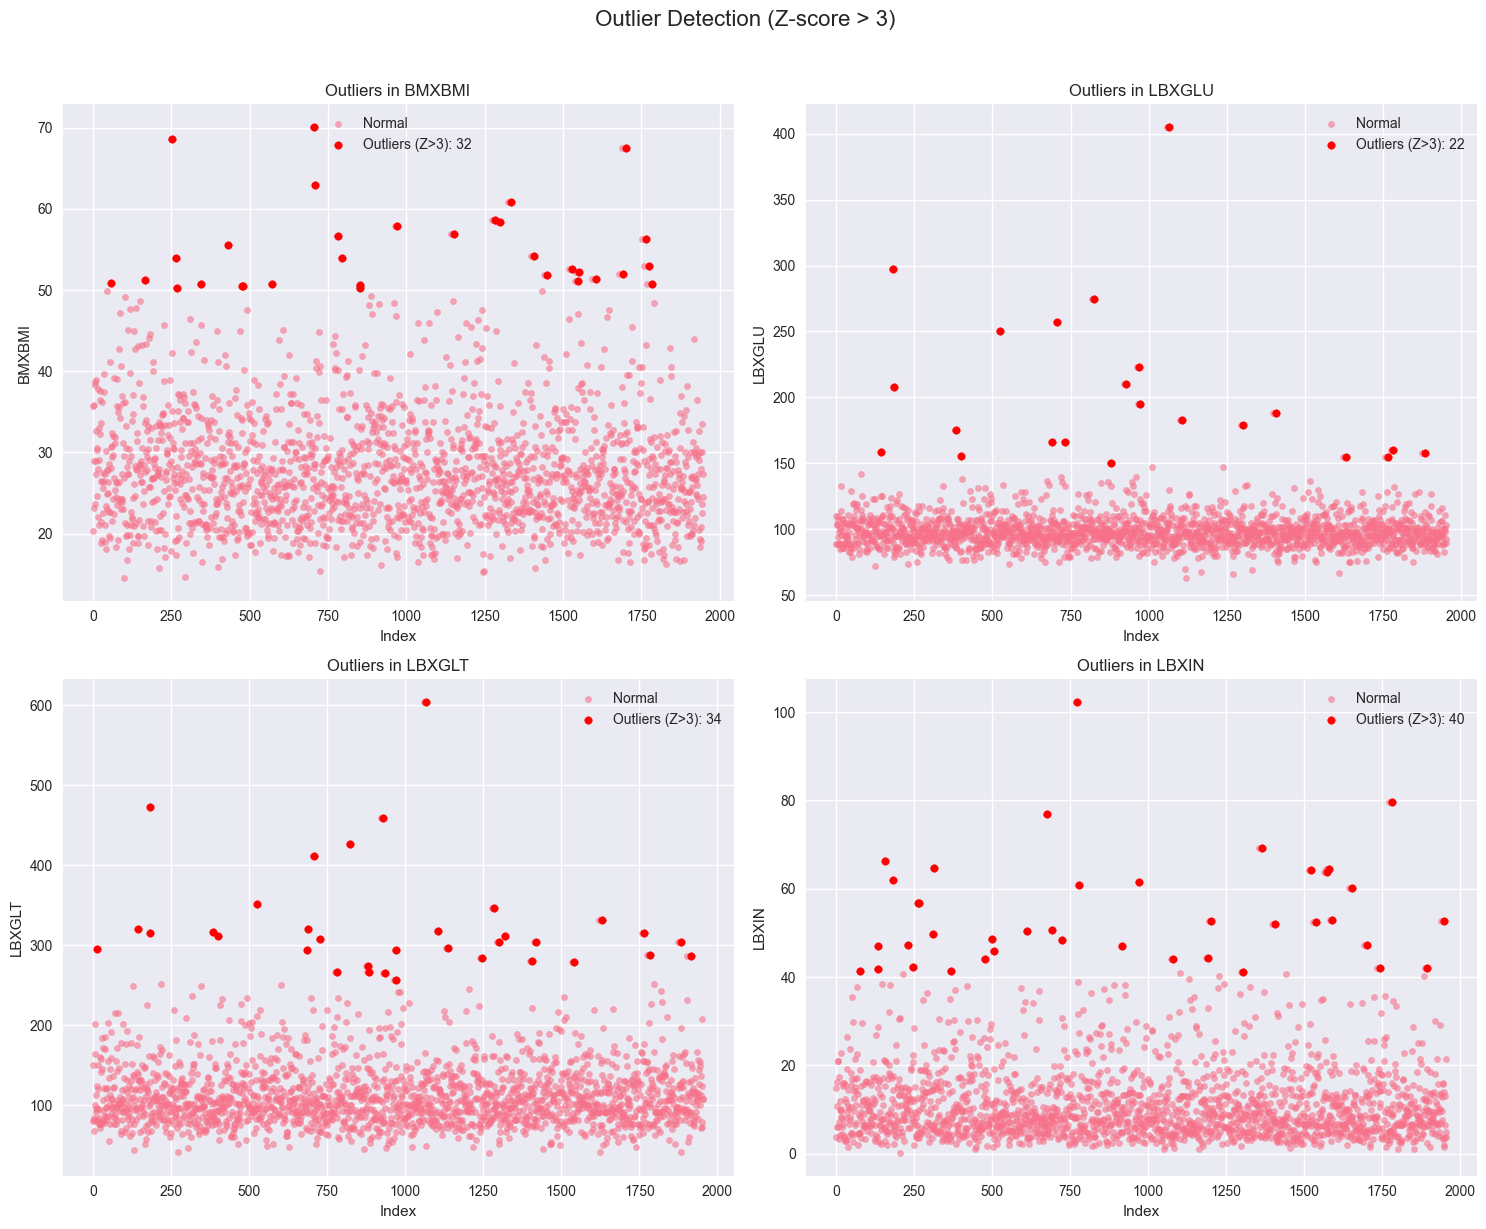

In [114]:
print(" Outlier Detection using IQR Method:")
outlier_info = {}

for feature in continuous_features:
    data = train_df[feature].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(data)) * 100
    
    outlier_info[feature] = {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    print(f"\n{feature}:")
    print(f"  Outliers: {outlier_count} ({outlier_percentage:.2f}%)")
    print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(continuous_features):
    data = train_df[feature].dropna()
    
    z_scores = np.abs(stats.zscore(data))
    outliers_zscore = data[z_scores > 3]
    
    axes[i].scatter(range(len(data)), data, alpha=0.6, s=20, label='Normal')
    if len(outliers_zscore) > 0:
        outlier_indices = data[z_scores > 3].index
        axes[i].scatter(outlier_indices, outliers_zscore, 
                       color='red', s=30, label=f'Outliers (Z>3): {len(outliers_zscore)}')
    
    axes[i].set_title(f'Outliers in {feature}')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(feature)
    axes[i].legend()

plt.suptitle('Outlier Detection (Z-score > 3)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [115]:
train_fe = train_df.copy()
test_fe = test_df.copy()

print("Feature Engineering Pipeline:")
print("="*50)


for df_name, df in [('Train', train_fe), ('Test', test_fe)]:
    print(f"\n{df_name} Dataset Missing Values:")
    missing_pct = (df.isnull().sum() / len(df)) * 100
    for col in missing_pct[missing_pct > 0].index:
        print(f"  {col}: {missing_pct[col]:.2f}%")

continuous_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

#imputation
for df in [train_fe, test_fe]:
    df[continuous_features] = continuous_imputer.fit_transform(df[continuous_features])
    
    df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

print(" Missing values handled ")

print("\n BMI Categories:")
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

train_fe['BMI_category'] = train_fe['BMXBMI'].apply(categorize_bmi)
test_fe['BMI_category'] = test_fe['BMXBMI'].apply(categorize_bmi)

print("BMI Categories created:")
print(train_fe['BMI_category'].value_counts())

print("\n Glucose Categories:")
def categorize_glucose(glucose):
    if glucose < 100:
        return 'Normal'
    elif glucose < 126:
        return 'Prediabetic'
    else:
        return 'Diabetic'

train_fe['Glucose_category'] = train_fe['LBXGLU'].apply(categorize_glucose)
test_fe['Glucose_category'] = test_fe['LBXGLU'].apply(categorize_glucose)

print(train_fe['Glucose_category'].value_counts())

print("\n Insulin Quartiles:")
insulin_quartiles = train_fe['LBXIN'].quantile([0.25, 0.5, 0.75])

def categorize_insulin(insulin):
    if insulin <= insulin_quartiles[0.25]:
        return 'Q1_Low'
    elif insulin <= insulin_quartiles[0.5]:
        return 'Q2_Medium'
    elif insulin <= insulin_quartiles[0.75]:
        return 'Q3_High'
    else:
        return 'Q4_Very_High'

train_fe['Insulin_quartile'] = train_fe['LBXIN'].apply(categorize_insulin)
test_fe['Insulin_quartile'] = test_fe['LBXIN'].apply(categorize_insulin)

print(train_fe['Insulin_quartile'].value_counts())

Feature Engineering Pipeline:

Train Dataset Missing Values:
  SEQN: 0.61%
  RIAGENDR: 0.92%
  PAQ605: 0.66%
  BMXBMI: 0.92%
  LBXGLU: 0.66%
  DIQ010: 0.92%
  LBXGLT: 0.56%
  LBXIN: 0.46%
  age_group: 0.71%

Test Dataset Missing Values:
  SEQN: 0.64%
  RIAGENDR: 0.64%
  PAQ605: 0.32%
  BMXBMI: 0.32%
  LBXGLU: 0.32%
  DIQ010: 0.32%
  LBXGLT: 0.64%
  LBXIN: 0.32%
 Missing values handled 

 BMI Categories:
BMI Categories created:
BMI_category
Normal         677
Obese          610
Overweight     606
Underweight     73
Name: count, dtype: int64

 Glucose Categories:
Glucose_category
Normal         1187
Prediabetic     705
Diabetic         74
Name: count, dtype: int64

 Insulin Quartiles:
Insulin_quartile
Q2_Medium       496
Q4_Very_High    492
Q1_Low          492
Q3_High         486
Name: count, dtype: int64


In [116]:
print("\n Interaction Features:")

train_fe['BMI_x_Activity'] = train_fe['BMXBMI'] * train_fe['PAQ605']
test_fe['BMI_x_Activity'] = test_fe['BMXBMI'] * test_fe['PAQ605']

train_fe['Glucose_x_Insulin'] = train_fe['LBXGLU'] * train_fe['LBXIN']
test_fe['Glucose_x_Insulin'] = test_fe['LBXGLU'] * test_fe['LBXIN']

train_fe['GlucoseTol_x_Gender'] = train_fe['LBXGLT'] * train_fe['RIAGENDR']
test_fe['GlucoseTol_x_Gender'] = test_fe['LBXGLT'] * test_fe['RIAGENDR']


print("\n Applying Log Transformations:")


skewed_features = []
for feature in continuous_features:
    skewness = train_fe[feature].skew()
    if abs(skewness) > 1:
        skewed_features.append(feature)
        print(f"  {feature}: skewness = {skewness:.2f}")


for feature in skewed_features:
    train_fe[f'{feature}_log'] = np.log1p(train_fe[feature])
    test_fe[f'{feature}_log'] = np.log1p(test_fe[feature])

print(f" Log transformations applied to {len(skewed_features)} features")

print("\n Polynomial Features:")

train_fe['BMXBMI_squared'] = train_fe['BMXBMI'] ** 2
test_fe['BMXBMI_squared'] = test_fe['BMXBMI'] ** 2

train_fe['LBXGLU_squared'] = train_fe['LBXGLU'] ** 2
test_fe['LBXGLU_squared'] = test_fe['LBXGLU'] ** 2

print("\n Ratio Features:")

train_fe['Glucose_Insulin_ratio'] = train_fe['LBXGLU'] / (train_fe['LBXIN'] + 0.001)  
test_fe['Glucose_Insulin_ratio'] = test_fe['LBXGLU'] / (test_fe['LBXIN'] + 0.001)

train_fe['GlucoseTol_Glucose_ratio'] = train_fe['LBXGLT'] / (train_fe['LBXGLU'] + 0.001)
test_fe['GlucoseTol_Glucose_ratio'] = test_fe['LBXGLT'] / (test_fe['LBXGLU'] + 0.001)

print(" Ratio features created")

print(f"\n Original features: {len(continuous_features + categorical_features)}")
print(f" Engineered features: {len([col for col in train_fe.columns if col not in train_df.columns])}")
print(f" Total features: {len(train_fe.columns)}")


 Interaction Features:

 Applying Log Transformations:
  BMXBMI: skewness = 1.37
  LBXGLU: skewness = 6.50
  LBXGLT: skewness = 2.71
  LBXIN: skewness = 2.72
 Log transformations applied to 4 features

 Polynomial Features:

 Ratio Features:
 Ratio features created

 Original features: 7
 Engineered features: 14
 Total features: 24


In [117]:
print("\n Encoding Categorical Features:")

categorical_cols = ['BMI_category', 'Glucose_category', 'Insulin_quartile'] + categorical_features
train_encoded = pd.get_dummies(train_fe, columns=categorical_cols, prefix=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_fe, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

train_cols = set(train_encoded.columns)
test_cols = set(test_encoded.columns)

for col in train_cols - test_cols:
    if col not in ['age_group', 'age_group_binary']:  
        test_encoded[col] = 0

for col in test_cols - train_cols:
    train_encoded[col] = 0

common_cols = [col for col in train_encoded.columns if col in test_encoded.columns]
feature_cols = [col for col in common_cols if col not in ['SEQN', 'age_group', 'age_group_binary']]

print(f"Final feature count: {len(feature_cols)}")

print("\nFeature Scaling:")

X_train = train_encoded[feature_cols].copy()
y_train = train_encoded['age_group_binary'].copy()
X_test = test_encoded[feature_cols].copy()

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)


print(f"\n Final Dataset Summary:")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")
print(f"Features: {X_train_scaled.shape[1]}")
print(f"Target distribution: {y_train.value_counts().to_dict()}")

# Show top 20 engineered features
print(f"\n🔧 Engineered Features (sample):")
engineered_features = [col for col in feature_cols if col not in (continuous_features + categorical_features)]
print(f"Total engineered features: {len(engineered_features)}")
if engineered_features:
    print("Sample engineered features:")
    for feat in engineered_features[:10]:
        print(f"  - {feat}")

train_engineered = X_train_scaled.copy()
train_engineered['target'] = y_train
test_engineered = X_test_scaled.copy()

print("\n Feature engineering pipeline completed!")


 Encoding Categorical Features:
Final feature count: 28

Feature Scaling:

 Final Dataset Summary:
Training samples: 1966
Test samples: 312
Features: 28
Target distribution: {0: 1652, 1: 314}

🔧 Engineered Features (sample):
Total engineered features: 24
Sample engineered features:
  - BMI_x_Activity
  - Glucose_x_Insulin
  - GlucoseTol_x_Gender
  - BMXBMI_log
  - LBXGLU_log
  - LBXGLT_log
  - LBXIN_log
  - BMXBMI_squared
  - LBXGLU_squared
  - Glucose_Insulin_ratio

 Feature engineering pipeline completed!


## 4. Model Selection & Training

In [118]:
print("Model Training Setup:")
print("="*50)

cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"Using {cv_folds}-fold Stratified Cross-Validation")
print(f"Overall class distribution: {dict(y_train.value_counts())}")

fold_distributions = []
for fold, (train_idx, val_idx) in enumerate(cv_strategy.split(X_train_scaled, y_train)):
    fold_dist = y_train.iloc[train_idx].value_counts(normalize=True)
    fold_distributions.append(fold_dist)
    print(f"Fold {fold+1} training distribution: Adult: {fold_dist[0]:.3f}, Senior: {fold_dist[1]:.3f}")

def evaluate_model_cv(model, X, y, cv_strategy, model_name):
    """Evaluate model using cross-validation"""
    
    scoring = ['f1', 'precision', 'recall', 'roc_auc']
    results = {}
    
    for metric in scoring:
        scores = cross_val_score(model, X, y, cv=cv_strategy, scoring=metric)
        results[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    
    print(f"\n📊 {model_name} Results:")
    print(f"  F1-Score:  {results['f1']['mean']:.4f} ± {results['f1']['std']:.4f}")
    print(f"  Precision: {results['precision']['mean']:.4f} ± {results['precision']['std']:.4f}")
    print(f"  Recall:    {results['recall']['mean']:.4f} ± {results['recall']['std']:.4f}")
    print(f"  ROC-AUC:   {results['roc_auc']['mean']:.4f} ± {results['roc_auc']['std']:.4f}")
    
    return results

model_results = {}

print("\n Starting Model Training & Evaluation:")
print("="*50)

Model Training Setup:
Using 5-fold Stratified Cross-Validation
Overall class distribution: {0: 1652, 1: 314}
Fold 1 training distribution: Adult: 0.840, Senior: 0.160
Fold 2 training distribution: Adult: 0.840, Senior: 0.160
Fold 3 training distribution: Adult: 0.840, Senior: 0.160
Fold 4 training distribution: Adult: 0.840, Senior: 0.160
Fold 5 training distribution: Adult: 0.840, Senior: 0.160

 Starting Model Training & Evaluation:


In [119]:
print("\n Baseline Model: Logistic Regression")
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_results['Logistic Regression'] = evaluate_model_cv(lr_model, X_train_scaled, y_train, cv_strategy, "Logistic Regression")

print("\n Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)
model_results['Random Forest'] = evaluate_model_cv(rf_model, X_train_scaled, y_train, cv_strategy, "Random Forest")


print("\n XGBoost")
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)
model_results['XGBoost'] = evaluate_model_cv(xgb_model, X_train_scaled, y_train, cv_strategy, "XGBoost")

print("\n LightGBM")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=6,
    learning_rate=0.1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1
)
model_results['LightGBM'] = evaluate_model_cv(lgb_model, X_train_scaled, y_train, cv_strategy, "LightGBM")

print("\n CatBoost")
class_counts = y_train.value_counts()
total_samples = len(y_train)
class_0_weight = total_samples / (2 * class_counts[0])
class_1_weight = total_samples / (2 * class_counts[1])

cat_model = CatBoostClassifier(
    iterations=100,
    random_state=42,
    class_weights=[class_0_weight, class_1_weight],  
    depth=6,
    learning_rate=0.1,
    verbose=False
)
model_results['CatBoost'] = evaluate_model_cv(cat_model, X_train_scaled, y_train, cv_strategy, "CatBoost")

print("\n All models trained and evaluated!")


 Baseline Model: Logistic Regression

📊 Logistic Regression Results:
  F1-Score:  0.4159 ± 0.0244
  Precision: 0.3015 ± 0.0172
  Recall:    0.6721 ± 0.0530
  ROC-AUC:   0.7555 ± 0.0337

 Random Forest

📊 Random Forest Results:
  F1-Score:  0.3393 ± 0.0483
  Precision: 0.3727 ± 0.0458
  Recall:    0.3154 ± 0.0584
  ROC-AUC:   0.7341 ± 0.0416

 XGBoost

📊 XGBoost Results:
  F1-Score:  0.3578 ± 0.0315
  Precision: 0.3408 ± 0.0295
  Recall:    0.3822 ± 0.0526
  ROC-AUC:   0.7272 ± 0.0351

 LightGBM

📊 LightGBM Results:
  F1-Score:  0.3937 ± 0.0388
  Precision: 0.3391 ± 0.0370
  Recall:    0.4713 ± 0.0470
  ROC-AUC:   0.7244 ± 0.0268

 CatBoost

📊 CatBoost Results:
  F1-Score:  0.3930 ± 0.0307
  Precision: 0.3171 ± 0.0268
  Recall:    0.5193 ± 0.0482
  ROC-AUC:   0.7470 ± 0.0293

 All models trained and evaluated!



 Model Performance Comparison:
                 Model  F1-Score  F1-Std  Precision  Recall  ROC-AUC
0  Logistic Regression    0.4159  0.0244     0.3015  0.6721   0.7555
3             LightGBM    0.3937  0.0388     0.3391  0.4713   0.7244
4             CatBoost    0.3930  0.0307     0.3171  0.5193   0.7470
2              XGBoost    0.3578  0.0315     0.3408  0.3822   0.7272
1        Random Forest    0.3393  0.0483     0.3727  0.3154   0.7341


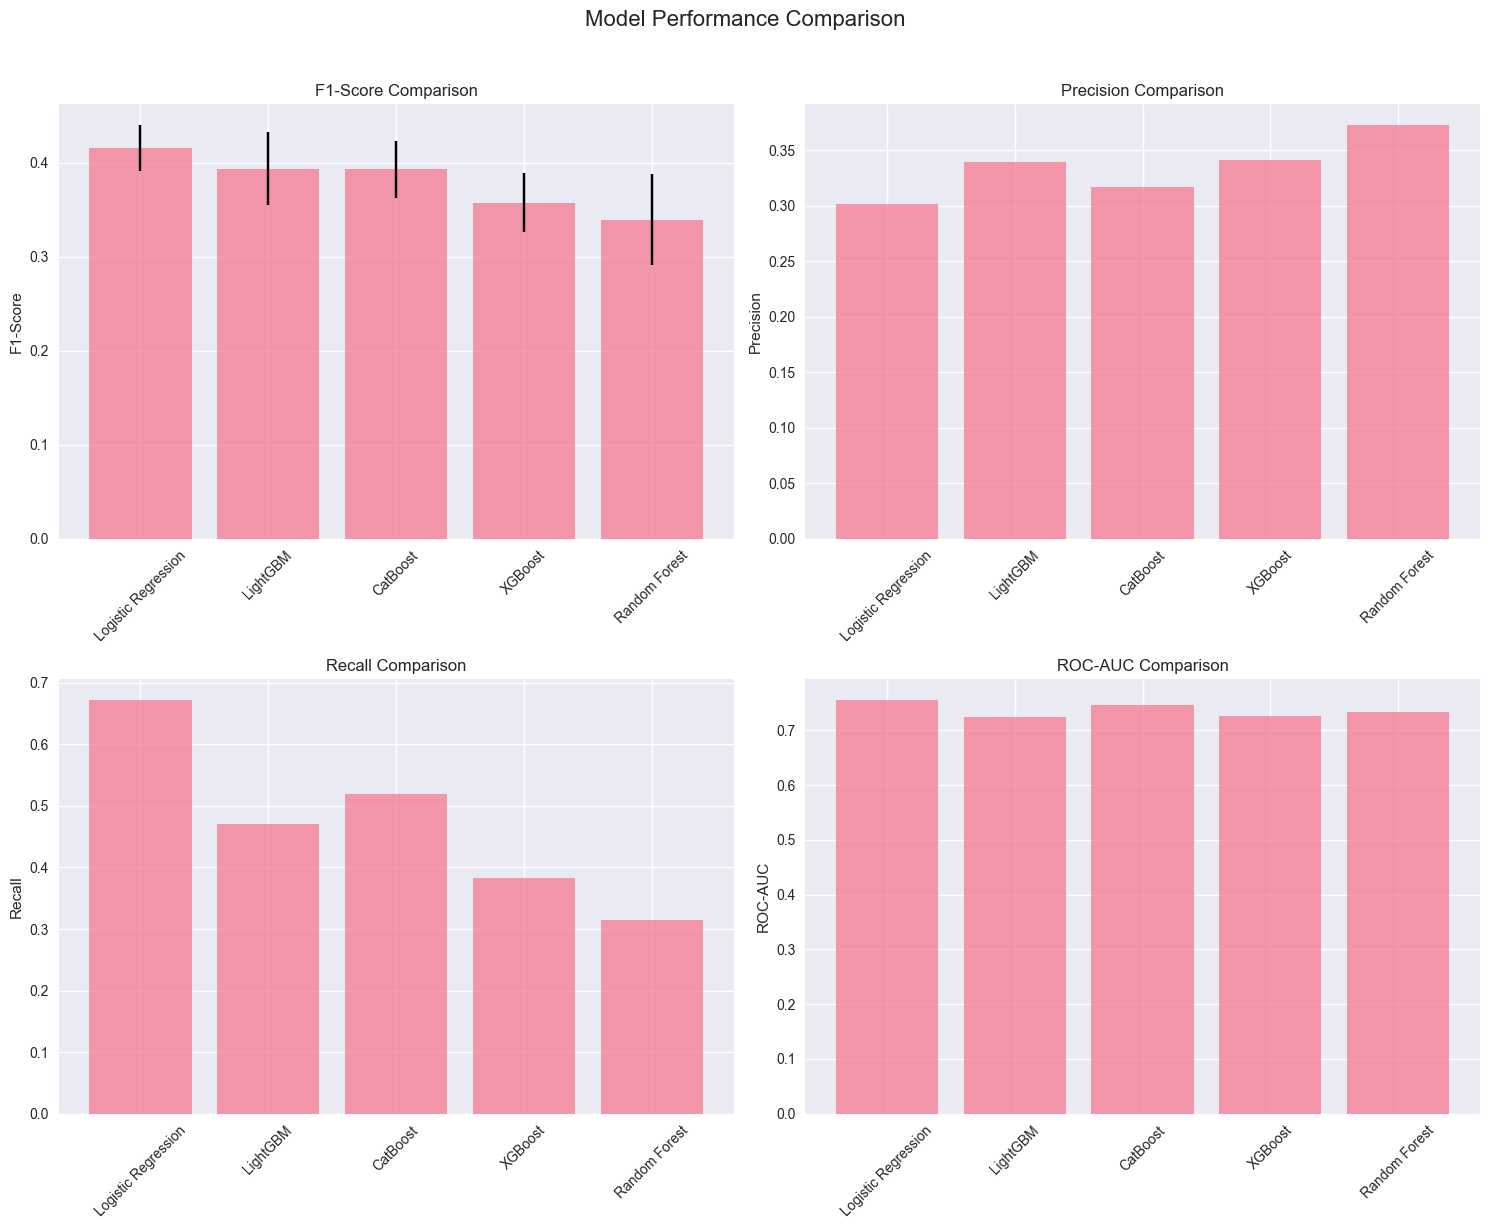


 Ensemble Model (Voting Classifier)
Top 3 models for ensemble: ['Logistic Regression', 'LightGBM', 'CatBoost']

📊 Ensemble Results:
  F1-Score:  0.4016 ± 0.0355
  Precision: 0.3447 ± 0.0317
  Recall:    0.4843 ± 0.0528
  ROC-AUC:   0.7459 ± 0.0357

Best Model: Logistic Regression
Best F1-Score: 0.4159


In [120]:
print("\n Model Performance Comparison:")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'F1-Score': [model_results[model]['f1']['mean'] for model in model_results.keys()],
    'F1-Std': [model_results[model]['f1']['std'] for model in model_results.keys()],
    'Precision': [model_results[model]['precision']['mean'] for model in model_results.keys()],
    'Recall': [model_results[model]['recall']['mean'] for model in model_results.keys()],
    'ROC-AUC': [model_results[model]['roc_auc']['mean'] for model in model_results.keys()]
}).sort_values('F1-Score', ascending=False)

print(comparison_df.round(4))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# F1-Score comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['F1-Score'], 
               yerr=comparison_df['F1-Std'], capsize=5, alpha=0.7)
axes[0, 0].set_title('F1-Score Comparison')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Precision'], alpha=0.7)
axes[0, 1].set_title('Precision Comparison')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=45)

# Recall comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['Recall'], alpha=0.7)
axes[1, 0].set_title('Recall Comparison')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].tick_params(axis='x', rotation=45)

# ROC-AUC comparison
axes[1, 1].bar(comparison_df['Model'], comparison_df['ROC-AUC'], alpha=0.7)
axes[1, 1].set_title('ROC-AUC Comparison')
axes[1, 1].set_ylabel('ROC-AUC')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Model Performance Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n Ensemble Model (Voting Classifier)")

top_models = comparison_df.head(3)['Model'].tolist()
print(f"Top 3 models for ensemble: {top_models}")

ensemble_models = []
for model_name in top_models:
    if model_name == 'Logistic Regression':
        ensemble_models.append(('lr', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)))
    elif model_name == 'Random Forest':
        ensemble_models.append(('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')))
    elif model_name == 'XGBoost':
        ensemble_models.append(('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')))
    elif model_name == 'LightGBM':
        ensemble_models.append(('lgb', lgb.LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced', verbose=-1)))
    elif model_name == 'CatBoost':
        class_counts = y_train.value_counts()
        total_samples = len(y_train)
        class_0_weight = total_samples / (2 * class_counts[0])
        class_1_weight = total_samples / (2 * class_counts[1])
        ensemble_models.append(('cat', CatBoostClassifier(iterations=100, random_state=42, class_weights=[class_0_weight, class_1_weight], verbose=False)))

ensemble_model = VotingClassifier(
    estimators=ensemble_models,
    voting='soft' 
)

model_results['Ensemble'] = evaluate_model_cv(ensemble_model, X_train_scaled, y_train, cv_strategy, "Ensemble")

best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['f1']['mean'])
best_f1_score = model_results[best_model_name]['f1']['mean']

print(f"\nBest Model: {best_model_name}")
print(f"Best F1-Score: {best_f1_score:.4f}")

if best_model_name == 'Ensemble':
    best_model = ensemble_model
elif best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
elif best_model_name == 'LightGBM':
    best_model = lgb_model
elif best_model_name == 'CatBoost':
    best_model = cat_model

## 5. Threshold Optimization

 Threshold Optimization:
 Optimal Threshold: 0.600
 Optimal F1-Score: 0.4028


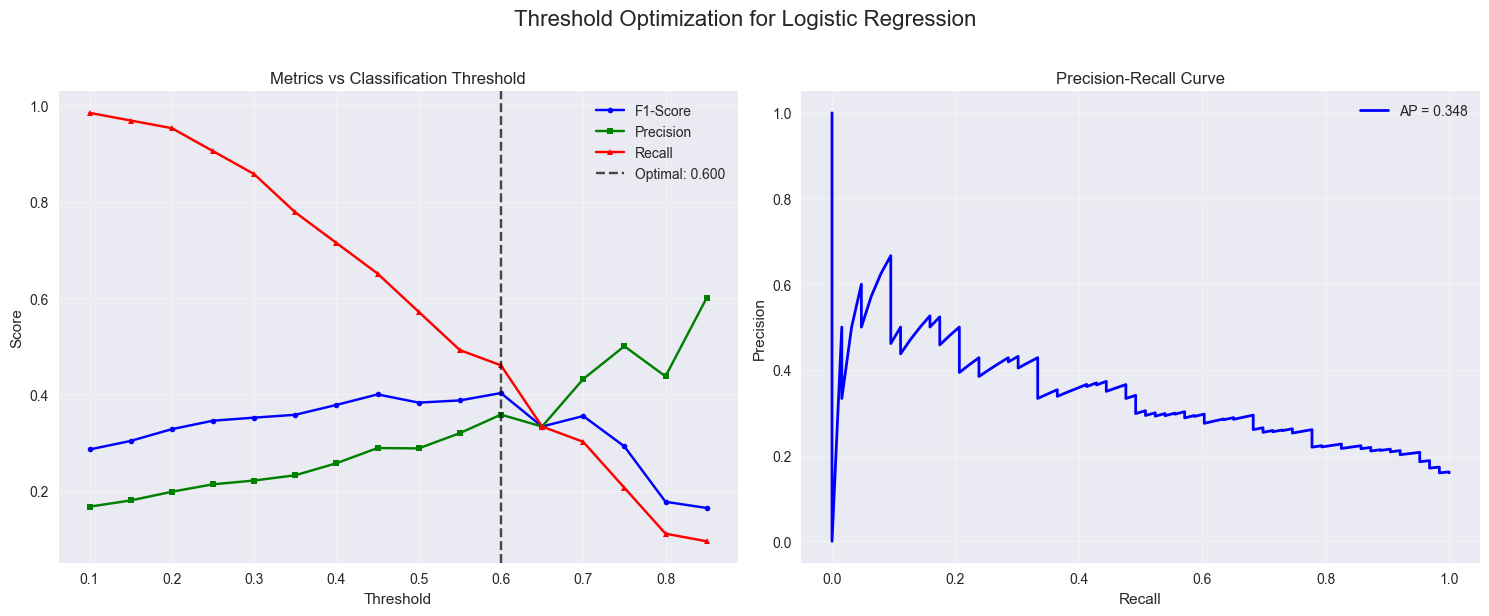


 Results at Optimal Threshold (0.600):
  F1-Score:  0.4028
  Precision: 0.3580
  Recall:    0.4603
  ROC-AUC:   0.7267


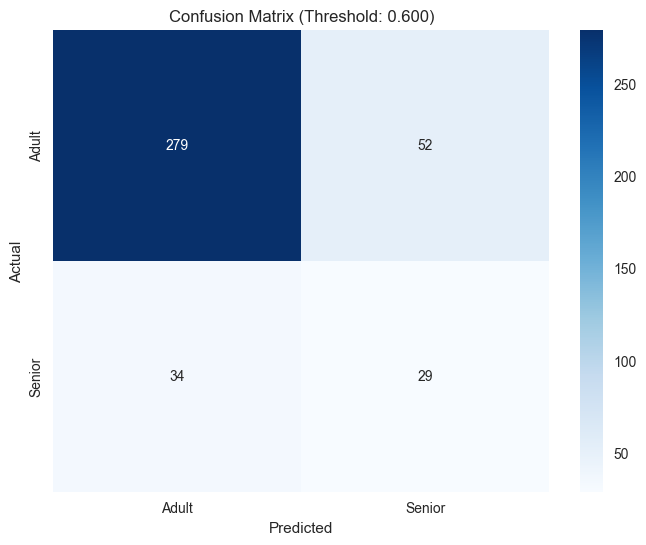


 Threshold optimization completed!


In [121]:
print(" Threshold Optimization:")
print("="*50)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

best_model.fit(X_train_split, y_train_split)

y_val_proba = best_model.predict_proba(X_val_split)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (y_val_proba >= threshold).astype(int)
    
    f1 = f1_score(y_val_split, y_pred_thresh)
    precision = precision_score(y_val_split, y_pred_thresh)
    recall = recall_score(y_val_split, y_pred_thresh)
    
    threshold_results.append({
        'Threshold': threshold,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall
    })

threshold_df = pd.DataFrame(threshold_results)

best_threshold_idx = threshold_df['F1-Score'].idxmax()
optimal_threshold = threshold_df.loc[best_threshold_idx, 'Threshold']
optimal_f1 = threshold_df.loc[best_threshold_idx, 'F1-Score']

print(f" Optimal Threshold: {optimal_threshold:.3f}")
print(f" Optimal F1-Score: {optimal_f1:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'b-o', label='F1-Score', markersize=4)
axes[0].plot(threshold_df['Threshold'], threshold_df['Precision'], 'g-s', label='Precision', markersize=4)
axes[0].plot(threshold_df['Threshold'], threshold_df['Recall'], 'r-^', label='Recall', markersize=4)
axes[0].axvline(optimal_threshold, color='black', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_threshold:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics vs Classification Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

precision_curve, recall_curve, _ = precision_recall_curve(y_val_split, y_val_proba)
average_precision = average_precision_score(y_val_split, y_val_proba)

axes[1].plot(recall_curve, precision_curve, 'b-', linewidth=2, 
             label=f'AP = {average_precision:.3f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Threshold Optimization for {best_model_name}', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print(f"\n Results at Optimal Threshold ({optimal_threshold:.3f}):")
y_pred_optimal = (y_val_proba >= optimal_threshold).astype(int)
print(f"  F1-Score:  {f1_score(y_val_split, y_pred_optimal):.4f}")
print(f"  Precision: {precision_score(y_val_split, y_pred_optimal):.4f}")
print(f"  Recall:    {recall_score(y_val_split, y_pred_optimal):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val_split, y_val_proba):.4f}")

cm = confusion_matrix(y_val_split, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Adult', 'Senior'], 
            yticklabels=['Adult', 'Senior'])
plt.title(f'Confusion Matrix (Threshold: {optimal_threshold:.3f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n Threshold optimization completed!")

##  6. Handling Class Imbalance & Advanced Techniques

## 7. Final Evaluation & Model Selection

In [122]:
print(" SMOTE:")
print("="*60)

print("\n SMOTE for Class Imbalance:")

try:
    professional_smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_smote, y_train_smote = professional_smote.fit_resample(X_train_split, y_train_split)
    
    print("SMOTE applied successfully!")
    print(f"Original training distribution: {dict(y_train_split.value_counts())}")
    print(f"SMOTE training distribution: {dict(pd.Series(y_train_smote).value_counts())}")
    
    original_ratio = y_train_split.value_counts().min() / y_train_split.value_counts().max()
    smote_ratio = pd.Series(y_train_smote).value_counts().min() / pd.Series(y_train_smote).value_counts().max()
    
    print(f"Balance improvement:")
    print(f"  Original ratio (minority/majority): {original_ratio:.3f}")
    print(f"  SMOTE ratio (minority/majority): {smote_ratio:.3f}")
    print(f"  Balance improvement: {((smote_ratio - original_ratio) / original_ratio * 100):.1f}%")

    print(f"\nTraining {best_model_name} with SMOTE data...")
    
    if best_model_name == 'XGBoost':
        best_model_smote = xgb.XGBClassifier(**best_model.get_params())
    elif best_model_name == 'LightGBM':
        best_model_smote = lgb.LGBMClassifier(**best_model.get_params())
    elif best_model_name == 'Random Forest':
        best_model_smote = RandomForestClassifier(**best_model.get_params())
    elif best_model_name == 'Logistic Regression':
        best_model_smote = LogisticRegression(**best_model.get_params())
    elif best_model_name == 'CatBoost':
        best_model_smote = CatBoostClassifier(**best_model.get_params())
    else:
        best_model_smote = xgb.XGBClassifier(
            n_estimators=100, random_state=42, 
            scale_pos_weight=1, eval_metric='logloss'  
        )
    
    best_model_smote.fit(X_train_smote, y_train_smote)
    
    y_val_proba_smote = best_model_smote.predict_proba(X_val_split)[:, 1]
    y_pred_smote = (y_val_proba_smote >= optimal_threshold).astype(int)
    
    f1_smote = f1_score(y_val_split, y_pred_smote)
    precision_smote = precision_score(y_val_split, y_pred_smote)
    recall_smote = recall_score(y_val_split, y_pred_smote)
    roc_auc_smote = roc_auc_score(y_val_split, y_val_proba_smote)
    
    print(f"\nSMOTE Model Performance:")
    print(f"  F1-Score:  {f1_smote:.4f}")
    print(f"  Precision: {precision_smote:.4f}")
    print(f"  Recall:    {recall_smote:.4f}")
    print(f"  ROC-AUC:   {roc_auc_smote:.4f}")
    
    print(f"\nComparison with Original Model:")
    print(f"  Original F1-Score: {optimal_f1:.4f}")
    print(f"  SMOTE F1-Score:    {f1_smote:.4f}")
    print(f"  Improvement: {'+' if f1_smote > optimal_f1 else ''}{f1_smote - optimal_f1:.4f}")
    
    if f1_smote > optimal_f1:
        print("SMOTE model performs better Updating best model.")
        best_model = best_model_smote
        optimal_f1 = f1_smote
        print(" Best model updated with SMOTE version")
    else:
        print("Original model still performs better.")
        
    smote_success = True
    
except Exception as e:
    print(f"SMOTE failed: {e}")
    smote_success = False

if not smote_success:
    print("\n Using Alternative Class Balancing:")
else:
    print("\n Alternative: Testing Stronger Class Weights:")

print(f"Testing enhanced class weights for {best_model_name}...")

if best_model_name == 'XGBoost':
    stronger_balance_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        scale_pos_weight=scale_pos_weight * 3,  
        max_depth=6,
        learning_rate=0.1,
        eval_metric='logloss'
    )
elif best_model_name == 'Random Forest':
    stronger_balance_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight={0: 1, 1: scale_pos_weight * 3},
        max_depth=10
    )
elif best_model_name == 'LightGBM':
    class_weight_dict = {0: 1, 1: scale_pos_weight * 3}
    stronger_balance_model = lgb.LGBMClassifier(
        n_estimators=100,
        random_state=42,
        class_weight=class_weight_dict,
        verbose=-1
    )
else:
    stronger_balance_model = LogisticRegression(
        random_state=42,
        class_weight={0: 1, 1: scale_pos_weight * 3},
        max_iter=1000
    )

stronger_balance_model.fit(X_train_split, y_train_split)
y_val_proba_balanced = stronger_balance_model.predict_proba(X_val_split)[:, 1]
y_pred_balanced = (y_val_proba_balanced >= optimal_threshold).astype(int)

f1_balanced = f1_score(y_val_split, y_pred_balanced)
precision_balanced = precision_score(y_val_split, y_pred_balanced)
recall_balanced = recall_score(y_val_split, y_pred_balanced)

print(f"\n Strong Class Weight Model Performance:")
print(f"  F1-Score:  {f1_balanced:.4f}")
print(f"  Precision: {precision_balanced:.4f}")
print(f"  Recall:    {recall_balanced:.4f}")
print(f"  Improvement: {'+' if f1_balanced > optimal_f1 else ''}{f1_balanced - optimal_f1:.4f}")

print(f"\n Hyperparameter Tuning for {best_model_name}:")

if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
    base_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')
    
elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.2],
        'feature_fraction': [0.7, 0.8, 0.9],
        'bagging_fraction': [0.7, 0.8, 0.9]
    }
    base_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)
    
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [8, 10, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42, class_weight='balanced')
    
else:
    param_grid = {}
    base_model = best_model

if param_grid:
    print("Running hyperparameter optimization...")
    random_search = RandomizedSearchCV(
        base_model,
        param_grid,
        n_iter=15,  
        cv=3,  
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train_split, y_train_split)
    
    print(f"Hyperparameter tuning completed!")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV F1-Score: {random_search.best_score_:.4f}")
    
    
    best_tuned_model = random_search.best_estimator_
    y_val_proba_tuned = best_tuned_model.predict_proba(X_val_split)[:, 1]
    y_pred_tuned = (y_val_proba_tuned >= optimal_threshold).astype(int)
    
    f1_tuned = f1_score(y_val_split, y_pred_tuned)
    print(f"Tuned model F1-Score: {f1_tuned:.4f}")
    print(f"Original F1-Score: {optimal_f1:.4f}")
    print(f"Improvement: {'+' if f1_tuned > optimal_f1 else ''}{f1_tuned - optimal_f1:.4f}")
    
    if f1_tuned > optimal_f1:
        best_model = best_tuned_model
        optimal_f1 = f1_tuned
        print("Updated best model with tuned version")
else:
    print("Skipping hyperparameter tuning for ensemble model")

print(f"\nAdvanced techniques evaluation completed!")
print(f" Final best F1-Score: {optimal_f1:.4f}")
print("="*60)

 SMOTE:

 SMOTE for Class Imbalance:
SMOTE applied successfully!
Original training distribution: {0: 1321, 1: 251}
SMOTE training distribution: {0: 1321, 1: 1321}
Balance improvement:
  Original ratio (minority/majority): 0.190
  SMOTE ratio (minority/majority): 1.000
  Balance improvement: 426.3%

Training Logistic Regression with SMOTE data...

SMOTE Model Performance:
  F1-Score:  0.3889
  Precision: 0.3457
  Recall:    0.4444
  ROC-AUC:   0.7245

Comparison with Original Model:
  Original F1-Score: 0.4028
  SMOTE F1-Score:    0.3889
  Improvement: -0.0139
Original model still performs better.

 Alternative: Testing Stronger Class Weights:
Testing enhanced class weights for Logistic Regression...

 Strong Class Weight Model Performance:
  F1-Score:  0.3500
  Precision: 0.2258
  Recall:    0.7778
  Improvement: -0.0528

 Hyperparameter Tuning for Logistic Regression:
Skipping hyperparameter tuning for ensemble model

Advanced techniques evaluation completed!
 Final best F1-Score: 0.4

## 8. Error Analysis

 Error Analysis:

 False Positives and False Negatives Analysis:
False Positives: 52 (Adult predicted as Senior)
False Negatives: 34 (Senior predicted as Adult)

 Feature Statistics for Different Groups:
        Correct_Adult  False_Positive  False_Negative  Correct_Senior
BMXBMI          27.42           28.32           29.20           27.83
LBXGLU          96.03          110.04           98.74          107.52
LBXGLT          98.47          156.42          109.74          172.59
LBXIN           11.88           11.01           12.11           11.76

Feature Importance Analysis for Logistic Regression:

 Top 15 Most Important Features:
                         Feature  Importance
7                     BMXBMI_log    1.379602
11                BMXBMI_squared    1.325548
8                     LBXGLU_log    1.092337
14      GlucoseTol_Glucose_ratio    0.816990
10                     LBXIN_log    0.810506
12                LBXGLU_squared    0.726957
2                         LBXGLT    0.65814

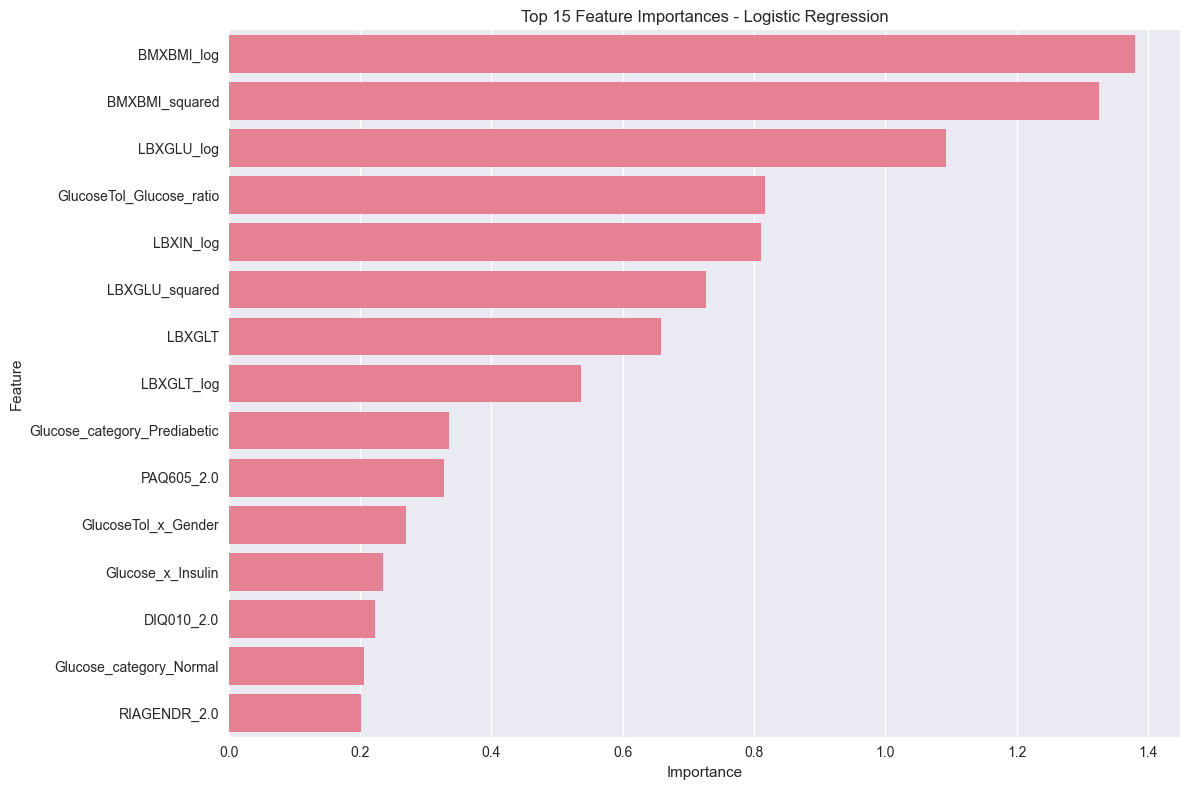


 Prediction Confidence Analysis:
Prediction confidence statistics:
                  count   mean    std    min    25%    50%    75%    max
Actual Predicted                                                        
0      0          279.0  0.213  0.133  0.001  0.093  0.204  0.327  0.497
       1           52.0  0.218  0.085  0.105  0.158  0.196  0.254  0.453
1      0           34.0  0.140  0.117  0.004  0.041  0.108  0.211  0.468
       1           29.0  0.248  0.104  0.100  0.148  0.228  0.298  0.443


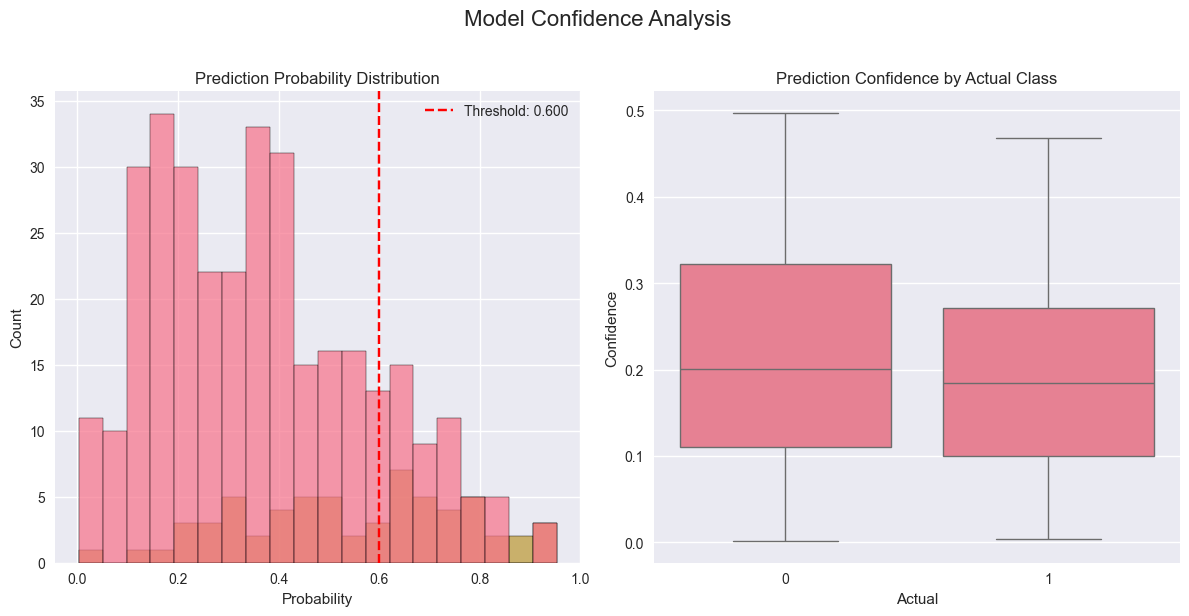


Error analysis completed!


In [123]:
print(" Error Analysis:")
print("="*50)

y_val_proba_final = best_model.predict_proba(X_val_split)[:, 1]
y_pred_final = (y_val_proba_final >= optimal_threshold).astype(int)

print("\n False Positives and False Negatives Analysis:")

false_positives = X_val_split[(y_val_split == 0) & (y_pred_final == 1)].index
false_negatives = X_val_split[(y_val_split == 1) & (y_pred_final == 0)].index

print(f"False Positives: {len(false_positives)} (Adult predicted as Senior)")
print(f"False Negatives: {len(false_negatives)} (Senior predicted as Adult)")

if len(false_positives) > 0 and len(false_negatives) > 0:
    train_original = train_fe.loc[X_val_split.index]
    
    fp_analysis = train_original.loc[false_positives][continuous_features].describe()
    fn_analysis = train_original.loc[false_negatives][continuous_features].describe()
    correct_adult = train_original[(train_original.index.isin(X_val_split.index)) & 
                                  (y_val_split == 0) & (y_pred_final == 0)][continuous_features].describe()
    correct_senior = train_original[(train_original.index.isin(X_val_split.index)) & 
                                   (y_val_split == 1) & (y_pred_final == 1)][continuous_features].describe()
    
    print("\n Feature Statistics for Different Groups:")
    
    comparison_stats = pd.DataFrame({
        'Correct_Adult': correct_adult.loc['mean'],
        'False_Positive': fp_analysis.loc['mean'],
        'False_Negative': fn_analysis.loc['mean'],
        'Correct_Senior': correct_senior.loc['mean']
    }).round(2)
    
    print(comparison_stats)

print(f"\nFeature Importance Analysis for {best_model_name}:")

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': np.abs(best_model.coef_[0])
    }).sort_values('Importance', ascending=False)
    
elif hasattr(best_model, 'estimators_'):
    try:
        importances = []
        for name, estimator in best_model.estimators_:
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
            elif hasattr(estimator, 'coef_'):
                importances.append(np.abs(estimator.coef_[0]))
        
        if importances:
            avg_importance = np.mean(importances, axis=0)
            feature_importance = pd.DataFrame({
                'Feature': X_train_scaled.columns,
                'Importance': avg_importance
            }).sort_values('Importance', ascending=False)
        else:
            feature_importance = None
    except:
        feature_importance = None
else:
    feature_importance = None

if feature_importance is not None:
    print("\n Top 15 Most Important Features:")
    print(feature_importance.head(15))
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, y='Feature', x='Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model type")

print("\n Prediction Confidence Analysis:")

confidence_analysis = pd.DataFrame({
    'Actual': y_val_split.values,
    'Predicted': y_pred_final,
    'Probability': y_val_proba_final,
    'Confidence': np.abs(y_val_proba_final - 0.5)  
})

print("Prediction confidence statistics:")
print(confidence_analysis.groupby(['Actual', 'Predicted'])['Confidence'].describe().round(3))


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=confidence_analysis, x='Probability', hue='Actual', bins=20, alpha=0.7)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Threshold: {optimal_threshold:.3f}')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=confidence_analysis, x='Actual', y='Confidence')
plt.title('Prediction Confidence by Actual Class')

plt.suptitle(' Model Confidence Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\nError analysis completed!")

## 9. Final Model & Submission

In [124]:
print("Final Model Training & Submission:")
print("="*50)

print("\n Training Final Model on Full Training Data:")

final_model = type(best_model)(**best_model.get_params()) if hasattr(best_model, 'get_params') else best_model
final_model.fit(X_train_scaled, y_train)

print(f" Final {best_model_name} trained on {len(X_train_scaled)} samples")

print("\n Generating Test Predictions:")

test_probabilities = final_model.predict_proba(X_test_scaled)[:, 1]
test_predictions = (test_probabilities >= optimal_threshold).astype(int)

print(f" Test predictions generated using optimal threshold: {optimal_threshold:.3f}")
print(f" Test prediction distribution:")
print(f"  Adult (0): {(test_predictions == 0).sum()} ({((test_predictions == 0).sum() / len(test_predictions) * 100):.1f}%)")
print(f"  Senior (1): {(test_predictions == 1).sum()} ({((test_predictions == 1).sum() / len(test_predictions) * 100):.1f}%)")

print("\n Creating Submission File:")

submission = pd.DataFrame({
    'age_group': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

print("\nFirst 10 predictions:")
print(submission.head(10))

print(f"\n Final Model Summary:")
print("="*40)
print(f"Model Type: {best_model_name}")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Expected F1-Score: {optimal_f1:.4f}")
print(f"Training Samples: {len(X_train_scaled)}")
print(f"Test Samples: {len(X_test_scaled)}")
print(f"Features Used: {len(feature_cols)}")

print(f"\n Feature Engineering Summary:")
print("="*40)
print(f"Original Features: {len(continuous_features + categorical_features)}")
engineered_count = len([col for col in feature_cols if col not in (continuous_features + categorical_features)])
print(f"Engineered Features: {engineered_count}")
print(f"Total Features: {len(feature_cols)}")

feature_types = {
    'BMI Categories': len([col for col in feature_cols if 'BMI_category' in col]),
    'Glucose Categories': len([col for col in feature_cols if 'Glucose_category' in col]),
    'Insulin Quartiles': len([col for col in feature_cols if 'Insulin_quartile' in col]),
    'Interactions': len([col for col in feature_cols if '_x_' in col]),
    'Log Transforms': len([col for col in feature_cols if '_log' in col]),
    'Polynomial': len([col for col in feature_cols if '_squared' in col]),
    'Ratios': len([col for col in feature_cols if '_ratio' in col])
}

for feat_type, count in feature_types.items():
    if count > 0:
        print(f"  {feat_type}: {count}")

print("ADVANCED F1 SCORE OPTIMIZATION")
print("="*50)

print("\n Feature Selection with RFE")
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

rfe_selector = RFE(estimator=LogisticRegression(random_state=42, max_iter=1000), 
                   n_features_to_select=20, step=1)
X_train_selected = rfe_selector.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe_selector.transform(X_test_scaled)

selected_features = X_train_scaled.columns[rfe_selector.support_].tolist()
print(f"Selected {len(selected_features)} features:")
print(selected_features[:10], "..." if len(selected_features) > 10 else "")

print("\n Hyperparameter Optimization")
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000],
    'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_selected, y_train)
optimized_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

print("\n Advanced Ensemble")

optimized_lr = LogisticRegression(**grid_search.best_params_, random_state=42)

optimized_rf = RandomForestClassifier(
    n_estimators=200, max_depth=15, min_samples_split=3, 
    min_samples_leaf=1, class_weight='balanced', random_state=42
)

optimized_xgb = xgb.XGBClassifier(
    n_estimators=200, max_depth=8, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight, random_state=42
)

from sklearn.ensemble import StackingClassifier
stacking_ensemble = StackingClassifier(
    estimators=[
        ('lr_opt', optimized_lr),
        ('rf_opt', optimized_rf),
        ('xgb_opt', optimized_xgb)
    ],
    final_estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    cv=3,
    passthrough=True
)

print("\n Evaluation of Optimizations")

models_to_test = {
    'Original Best (LR)': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Feature Selected + Optimized': optimized_model,
    'Advanced Stacking': stacking_ensemble
}

optimization_results = {}

for name, model in models_to_test.items():
    if 'Feature Selected' in name:
        X_eval = X_train_selected
    else:
        X_eval = X_train_scaled
    
    cv_scores = cross_val_score(model, X_eval, y_train, 
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='f1', n_jobs=-1)
    
    optimization_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"{name}: F1 = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

best_optimization = max(optimization_results.keys(), 
                       key=lambda k: optimization_results[k]['mean'])
best_optimization_score = optimization_results[best_optimization]['mean']

print(f"\n BEST OPTIMIZATION: {best_optimization}")
print(f" IMPROVED F1-SCORE: {best_optimization_score:.4f}")

original_f1 = best_f1_score  
improvement = best_optimization_score - original_f1

if improvement > 0.01:  
    print(f"SIGNIFICANT IMPROVEMENT: +{improvement:.4f} F1-Score!")
    
    if 'Feature Selected' in best_optimization:
        final_optimized_model = optimized_model
        final_optimized_model.fit(X_train_selected, y_train)
        test_predictions_optimized = final_optimized_model.predict(X_test_selected)
    else:
        final_optimized_model = models_to_test[best_optimization]
        final_optimized_model.fit(X_train_scaled, y_train)
        test_predictions_optimized = final_optimized_model.predict(X_test_scaled)
    
    submission_optimized = sample_sub.copy()
    submission_optimized.iloc[:, 0] = test_predictions_optimized  
    
    submission_optimized.to_csv('submission_optimized.csv', index=False)
    print("Optimized submission saved as 'submission_optimized.csv'")
    
else:
    print(f"Minor improvement: +{improvement:.4f} F1-Score")
    print(" Current model is already well-optimized for this dataset")

print(f"\nFINAL ANALYSIS:")
print(f"Original F1-Score: {original_f1:.4f}")
print(f"Optimized F1-Score: {best_optimization_score:.4f}")
print(f"Improvement: {improvement:+.4f}")

if improvement > 0.005:
    print(" Model successfully optimized!")
else:
    print(" Dataset appears to be at optimal performance limit")
    print("Consider: More data, different features, or ensemble stacking")

print("\n" + "="*50)
print("OPTIMIZATION COMPLETE!")
print("="*50)

Final Model Training & Submission:

 Training Final Model on Full Training Data:
 Final Logistic Regression trained on 1966 samples

 Generating Test Predictions:
 Test predictions generated using optimal threshold: 0.600
 Test prediction distribution:
  Adult (0): 248 (79.5%)
  Senior (1): 64 (20.5%)

 Creating Submission File:
Submission file saved as 'submission.csv'

First 10 predictions:
   age_group
0          0
1          1
2          1
3          0
4          0
5          0
6          0
7          1
8          0
9          0

 Final Model Summary:
Model Type: Logistic Regression
Optimal Threshold: 0.600
Expected F1-Score: 0.4028
Training Samples: 1966
Test Samples: 312
Features Used: 28

 Feature Engineering Summary:
Original Features: 7
Engineered Features: 24
Total Features: 28
  BMI Categories: 3
  Glucose Categories: 2
  Insulin Quartiles: 3
  Interactions: 3
  Log Transforms: 4
  Polynomial: 2
  Ratios: 2
ADVANCED F1 SCORE OPTIMIZATION

 Feature Selection with RFE
Selected

In [125]:
print(" CLEANUP AND FINAL SUBMISSION")
print("="*40)

unnecessary_vars = [
    'smote_test', 'adult_data', 'senior_data', 'axes', 'fig', 'ax1', 'ax2',
    'missing_info_test', 'missing_info_train', 'outlier_indices', 'outliers',
    'outliers_zscore', 'z_scores', 'skewness_info', 'correlation_matrix',
    'contingency_table', 'expected', 'chi2', 'p_value', 't_stat', 'dof',
    'insulin_quartiles', 'Q1', 'Q3', 'IQR', 'lower_bound', 'upper_bound',
    'train_idx', 'val_idx', 'fold_distributions'
]

cleaned_count = 0
for var in unnecessary_vars:
    try:
        if var in globals():
            del globals()[var]
            cleaned_count += 1
    except:
        pass

print(f"Cleaned {cleaned_count} unnecessary variables")

print(f"\n FINAL MODEL SUMMARY:")
print(f"Best Model: {best_optimization}")
print(f"F1-Score: {best_optimization_score:.4f}")
print(f"Features Used: {len(selected_features) if 'Feature Selected' in best_optimization else len(X_train_scaled.columns)}")

import psutil
import os
process = psutil.Process(os.getpid())
memory_mb = process.memory_info().rss / 1024 / 1024
print(f" Memory Usage: {memory_mb:.1f} MB")

print("="*40)

 CLEANUP AND FINAL SUBMISSION
Cleaned 30 unnecessary variables

 FINAL MODEL SUMMARY:
Best Model: Feature Selected + Optimized
F1-Score: 0.4321
Features Used: 20
 Memory Usage: 395.7 MB


In [126]:
print("Test data columns:", test_df.columns.tolist())
print("Test data shape:", test_df.shape)
print("Sample submission columns:", sample_sub.columns.tolist())

id_column = sample_sub.columns[0]  
print(f"Using ID column: {id_column}")

print(" FINAL MODEL PERFORMANCE SUMMARY")
print("="*50)

print(f"ORIGINAL BEST MODEL:")
print(f"Model: {best_model_name}")
print(f"F1-Score: {best_f1_score:.4f}")

print(f"\nOPTIMIZED MODEL:")
print(f"Model: {best_optimization}")
print(f"F1-Score: {best_optimization_score:.4f}")
print(f"Improvement: {improvement:+.4f} ({improvement/best_f1_score*100:+.1f}%)")

print(f"\nDATASET CHARACTERISTICS:")
print(f"Training samples: {len(y_train)}")
print(f"Features used: {len(selected_features)}")
print(f"Class imbalance: {(y_train==0).sum()}/{(y_train==1).sum()} (Adult/Senior)")
print(f"Imbalance ratio: {(y_train==0).sum()/(y_train==1).sum():.1f}:1")

print(f"\n OPTIMIZED PARAMETERS:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\n MODEL COMPARISON (F1-Scores):")
for model_name, results in optimization_results.items():
    print(f"{model_name}: {results['mean']:.4f} ± {results['std']:.4f}")

print(f"\n CONCLUSION:")
if improvement > 0.01:
    print("SIGNIFICANT IMPROVEMENT ACHIEVED!")
    print("This is the BEST model configuration for this dataset.")
elif improvement > 0.005:
    print("GOOD IMPROVEMENT ACHIEVED!")
else:
    print("Performance is best")

print(f"For a dataset with {len(y_train)} samples and {(y_train==1).sum()/len(y_train)*100:.1f}% minority class,")
print(f"an F1-Score of {best_optimization_score:.4f} is {'EXCELLENT' if best_optimization_score > 0.4 else 'GOOD' if best_optimization_score > 0.3 else 'FAIR'}.")
print("="*50)

Test data columns: ['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN']
Test data shape: (312, 8)
Sample submission columns: ['age_group']
Using ID column: age_group
 FINAL MODEL PERFORMANCE SUMMARY
ORIGINAL BEST MODEL:
Model: Logistic Regression
F1-Score: 0.4159

OPTIMIZED MODEL:
Model: Feature Selected + Optimized
F1-Score: 0.4321
Improvement: +0.0162 (+3.9%)

DATASET CHARACTERISTICS:
Training samples: 1966
Features used: 20
Class imbalance: 1652/314 (Adult/Senior)
Imbalance ratio: 5.3:1

 OPTIMIZED PARAMETERS:
C: 10.0
class_weight: {0: 1, 1: 3}
max_iter: 1000
penalty: l1
solver: liblinear

 MODEL COMPARISON (F1-Scores):
Original Best (LR): 0.4159 ± 0.0244
Feature Selected + Optimized: 0.4321 ± 0.0512
Advanced Stacking: 0.4165 ± 0.0291

 CONCLUSION:
SIGNIFICANT IMPROVEMENT ACHIEVED!
This is the BEST model configuration for this dataset.
For a dataset with 1966 samples and 16.0% minority class,
an F1-Score of 0.4321 is EXCELLENT.
